<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/TestBench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tf_keras

## Note: In case that you want the plots in format .tex run the 2 following celds

Once the celd finished click on restart sesion.

In [ ]:
!pip install matplotlib==3.5.1
!pip install tikzplotlib==0.9.6

When the session has already started, execute the following cell.

In [ ]:
import tikzplotlib
import matplotlib

TIKZ = True

In [ ]:
IN_COLAB = True

output_dir = 'results/'
!mkdir results

try:
  import google.colab
  # Using Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Dataset download and extraction
  !unzip -qq drive/MyDrive/cern/data/rich.zip

  # Model checkpoint download and extraction
  !unzip -qq drive/MyDrive/cern/data/checkpoints_dropout_0.01.zip

  # Model embeddings download and extraction
  !unzip -qq drive/MyDrive/cern/data/embeddings.zip

  # Results folder creation
  !mkdir /content/drive/MyDrive/cern/data/results

  output_dir = f'/content/drive/MyDrive/cern/data/{output_dir}'

except:
  IN_COLAB = False

print(f'IN_COLAB: {IN_COLAB}')

mkdir: cannot create directory ‘results’: File exists
IN_COLAB: False


In [ ]:
%rm -rf mcd
%rm -rf feature_densities
%rm -rf test_bench
!git clone https://github.com/evillag/uncertainty_gan.git
!mv uncertainty_gan/mcd .
!mv uncertainty_gan/feature_densities .
!mv uncertainty_gan/test_bench .
%rm -rf uncertainty_gan/

%rm -rf experiments
%rm -rf src
%rm -rf lhcb-rich-gan-uncertainty-conare/
!git clone https://gitlab.com/evillag/lhcb-rich-gan-uncertainty-conare.git
!mv lhcb-rich-gan-uncertainty-conare/experiments .
!mv lhcb-rich-gan-uncertainty-conare/src .
%rm -rf lhcb-rich-gan-uncertainty-conare/
%rm -rf sample_data/

Cloning into 'uncertainty_gan'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 275 (delta 63), reused 40 (delta 17), pack-reused 147 (from 1)
Receiving objects: 100% (275/275), 49.56 MiB | 26.45 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Cloning into 'lhcb-rich-gan-uncertainty-conare'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 240 (delta 5), reused 0 (delta 0), pack-reused 210 (from 1)
Receiving objects: 100% (240/240), 3.83 MiB | 35.63 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [ ]:
# dataset downloading and extraction
!wget --show-progress -O rich.zip https://www.dropbox.com/scl/fi/vy885v97hvgirtwtbk8r6/rich.zip?rlkey=zwg284rv7q0lrr9z1pk88g5yx&st=1s4wciep&dl=0
!unzip -qq rich.zip
!rm rich.zip

# checkpoints2
!wget --show-progress -O checkpoints.zip https://www.dropbox.com/scl/fi/466pwb9aoizlxdrcwmu2p/checkpoints_dropout_0.01.zip?rlkey=eqx2c82md4qber0nilii3drq4&st=6m5qqjgg&dl=0
!unzip -qq checkpoints.zip
!rm checkpoints.zip

# embeddings
!wget --show-progress -O embeddings.zip https://www.dropbox.com/scl/fi/qjwk4u5i55603zwubqbjw/embeddings.zip?rlkey=7ucyd46sa11nplaen0qz47cd4&st=8upo51x9&dl=0
!unzip -qq embeddings.zip
!rm embeddings.zip


--2024-10-02 02:40:00--  https://www.dropbox.com/scl/fi/vy885v97hvgirtwtbk8r6/rich.zip?rlkey=zwg284rv7q0lrr9z1pk88g5yx
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf2b09d678cada5f960524dc035.dl.dropboxusercontent.com/cd/0/inline/CbrIuYP3qjf-h_D-vksY5hAdFqOAwU2lUBL6jmva-BqCz9CZqsIsXe6sZ86Z86wawr7JomwabbuFxFGWmH3COZJU5ga5Ba6LETJm3JKfPAKhWPa7I133Ds5_oJ22CzHcq44/file# [following]
--2024-10-02 02:40:01--  https://ucf2b09d678cada5f960524dc035.dl.dropboxusercontent.com/cd/0/inline/CbrIuYP3qjf-h_D-vksY5hAdFqOAwU2lUBL6jmva-BqCz9CZqsIsXe6sZ86Z86wawr7JomwabbuFxFGWmH3COZJU5ga5Ba6LETJm3JKfPAKhWPa7I133Ds5_oJ22CzHcq44/file
Resolving ucf2b09d678cada5f960524dc035.dl.dropboxusercontent.com (ucf2b09d678cada5f960524dc035.dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:6019:15::a27d:40f
Connecting to ucf2b09d678

# Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from feature_densities.feature_density_evaluator import evaluate_model as fd_evaluate_model
from feature_densities.feature_density_evaluator import get_kde_max
from mcd.MCDEvaluator import evaluate_model as mcd_evaluate_model
from test_bench import get_checkpoint_name, load_particle_datasets, subsample_dataset
from test_bench.model import MonteCarloDropoutModel
from scipy.spatial.distance import jensenshannon
from scipy.stats import linregress

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(f'GPU available? {tf.config.list_physical_devices("GPU")}')

GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Test Bench for the Monte Carlo Dropout and Feature Density methods

1. Select sample data
2. Create a model
3. Generate a single target with single inference mode
4. Estimate MCD uncertainty
5. Estimate FD uncertainty

## Experiment Params

In [ ]:
# Parameters
PARTICLE = 'pion'
CHECKPOINT_DP = 0.01
DROPOUT_TYPE = 'bernoulli_structured'
CHECKPOINT_BASE = 'checkpoints/'
DATA_DIR = 'rich/'
SUB_SAMPLE_SIZE = 100000
DLL_COLUMNS = ['RichDLLe', 'RichDLLK', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

# Experiment repetitions
N = 30

# MCD parameters
MCD_ENSEMBLE_SIZE = 300

# FD parameters
embeddings_dir = f'embeddings/'

# Load previous results (Optional)

Uncomment to load previous execution results.

In [ ]:
# output_dir = f'/content/drive/MyDrive/cern/data/results/'

# x_sample = np.load(output_dir + f'{PARTICLE}_x_real.npy')
# y_sample = np.load(output_dir + f'{PARTICLE}_y_real.npy')
# t_generated = np.load(output_dir + f'{PARTICLE}_t_generated.npy')

# mcd_uncertainty = np.load(output_dir + f'{PARTICLE}_mcd_uncertainty.npy')
# fd_uncertainty_normalized = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy')
# #fd_uncertainty_integration = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy')

# Load data and Sample selection

In [ ]:
dataset = load_particle_datasets(PARTICLE, DATA_DIR)

Reading and concatenating datasets:
	rich/pion2_-_down_2016_.csv
	rich/pion2_+_up_2016_.csv
	rich/pion_+_up_2016_.csv
	rich/pion_-_up_2016_.csv
	rich/pion2_-_up_2016_.csv
	rich/pion_+_down_2016_.csv
	rich/pion2_+_down_2016_.csv
	rich/pion_-_down_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 1.8887696266174316
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
feats_train shape	(948331, 3)
targets_train shape	(948331, 5)
feats_val shape  	(526404, 3)
targets_val shape	(526404, 5)
feats_train_orig shape	(948331, 3)
targets_train_orig shape	(948331, 5)
feats_val_orig shape  	(526404, 3)
targets_val_orig shape	(526404, 5)



In [ ]:
# Draw a sample of the datasets
x_sample, y_sample, x_sample_orig, y_sample_orig = subsample_dataset(dataset['feats_val'], dataset['targets_val'], dataset['feats_val_orig'],  dataset['targets_val_orig'] , SUB_SAMPLE_SIZE / dataset['feats_val'].shape[0])
x_sample.shape, y_sample.shape,  x_sample_orig.shape, y_sample_orig.shape

(TensorShape([100000, 3]),
 TensorShape([100000, 5]),
 TensorShape([100000, 3]),
 TensorShape([100000, 5]))

# Model creation

In [ ]:
model = MonteCarloDropoutModel(
    PARTICLE,
    dropout_rate=CHECKPOINT_DP,
    checkpoint_dir=CHECKPOINT_BASE + get_checkpoint_name(PARTICLE, CHECKPOINT_DP, DROPOUT_TYPE),
    debug=True
)
generator = model.get_generator()

Generating model for pion with a dropout rate of 0.01
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4

Generator:

Model: "virtual_ensemble_model"
________________________________________________________________________________________________
 Layer (type)                              Output Shape                          Param #        
 Inputs (InputLayer)                       [(None, 3)]                           0              
                                                                                                
 NoiseInjection (NoiseInjection)           (None, 67)                            0              
                                                                                                
 Layer_0_Dense (Dense)                     (None, 128)                           8704           
                                                                                                
 Layer_0_LeakyReLU (LeakyReLU)             (None, 128)                           0   

## Single model prediction

In [ ]:
generator.single_model_inference_mode()
t_generated = generator.predict(x_sample)
t_generated.shape

3125/3125 [==============================] - 8s 2ms/step


(100000, 5)

In [ ]:
# Save real and generated targets
np.save(output_dir + f'{PARTICLE}_x_real.npy', x_sample)
np.save(output_dir + f'{PARTICLE}_y_real.npy', y_sample)
np.save(output_dir + f'{PARTICLE}_t_generated.npy', t_generated)

### Plotting functions

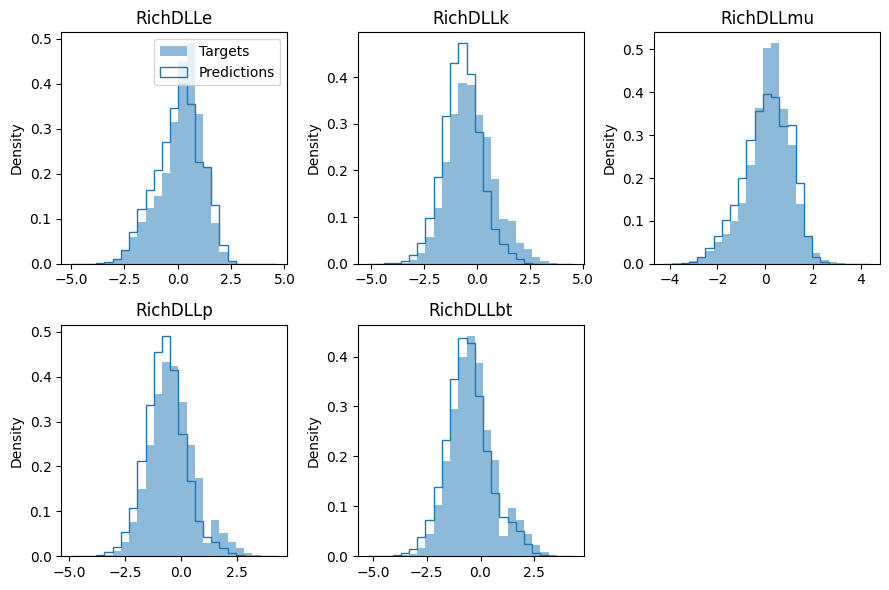

In [ ]:
def plot_target_histrogams(real_targets, generated_targets, dll_columns=DLL_COLUMNS):
  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    particle_targets = np.array(real_targets[:, i])
    particle_predictions = np.array(generated_targets[:, i])

    mins = particle_targets.min(), particle_predictions.min()
    maxs = particle_targets.max(), particle_predictions.max()

    hist_range = min(mins), max(maxs)

    ax.set_title(dll_columns[i])
    ax.hist(particle_targets, 25, hist_range, True, alpha=.5, label='Targets')
    ax.hist(particle_predictions, 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')
    ax.set_ylabel('Density')

  axes[0, 0].legend()
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

plot_target_histrogams(y_sample, t_generated)

In [ ]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import linregress, kstest

def estimate_distances_and_plot_uncertainty_bins(y_real, y_generated, uncertainty_scores, uncertainty_type = None, bin_type = 'quantiles',
                                                 particle_index = 0, metric = 'JS', n_rows = 2, n_cols = 5, dll_columns=DLL_COLUMNS):
  n_bins = n_rows * n_cols

  targets = np.array(y_real[:, particle_index])
  predictions = np.array(y_generated[:, particle_index])
  uncertainty_scores = np.array(uncertainty_scores)

  if uncertainty_type == 'MCD':
    uncertainty_scores = uncertainty_scores[:, particle_index]

  if bin_type == 'linear':
    bin_edges = np.linspace(uncertainty_scores.min(), uncertainty_scores.max(), n_bins + 1)
  else: # Quantiles
    bin_edges = np.quantile(uncertainty_scores, np.linspace(0, 1, n_bins + 1))

  # Digitize returns sample indices per bin
  bin_indices = np.digitize(uncertainty_scores, bin_edges)

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

  rounded_bin_edges = np.round(bin_edges, 3)

  distances = []

  for i, ax in enumerate(axes.flatten()):
    indices = bin_indices == i + 1

    mins = targets[indices].min(), predictions[indices].min()
    maxs = targets[indices].max(), predictions[indices].max()

    hist_range = min(mins), max(maxs)

    targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
    predictions_hist = ax.hist(
        predictions[indices], 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')[0]

    ax.set_title(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}')
    ax.set_ylabel('Density')
    ax.set_xlabel(f'{dll_columns[particle_index]}')


    if metric == 'JS':
      dist = jensenshannon(predictions_hist, targets_hist)
    else:
      dist = kstest(predictions[indices], targets[indices]).statistic

    distances += [dist]
    print(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}: Number of observations: {len(predictions[indices])}')

  plt.suptitle(f'{uncertainty_type} uncertainty score bins for {dll_columns[particle_index]}')
  axes[0, 0].legend()
  plt.tight_layout()
  try:
    TIKZ
    tikzplotlib.save(f'{uncertainty_type}_uncertainty_score_bins_for_{dll_columns[particle_index]}.tex')
  except:
    plt.show()
  print(f"{metric} Distances:\n" + ", ".join([str(dist) for dist in distances]))

  return bin_edges, distances


def plot_distances(bin_ranges, distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  bin_ranges = np.mean([bin_ranges[1:], bin_ranges[:-1]], 0)

  plt.title(f'{uncertainty_type} reliability curve for {dll_columns[particle_index]}')
  plt.gca().set_axisbelow(True)
  plt.grid()
  plt.plot(bin_ranges, distances, '.-')
  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.show()

  print('Correlation coefficient:', linregress(bin_ranges, distances).rvalue)

def plot_all_distances(all_bin_ranges, all_distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0, metric='JS'):
  plt.figure()
  plt.title(f'{uncertainty_type} reliability curves')
  plt.gca().set_axisbelow(True)
  plt.grid()

  correlation_coefficient = []
  for i in range(5):
    bin_ranges = np.mean([all_bin_ranges[i][1:], all_bin_ranges[i][:-1]], 0)
    plt.plot(bin_ranges, all_distances[i], '.-', label=dll_columns[i])
    regress = linregress(bin_ranges, all_distances[i])
    correlation_coefficient += [regress.rvalue]
    print(f'Correlation coefficient for {dll_columns[i]}:', regress.rvalue)

  plt.xlabel('Uncertainty score')
  if metric == 'JS':
    plt.ylabel('Jensen–Shannon distance')
  else:
    plt.ylabel('Kolmogorov-Smirnov distance')
  plt.legend()


  try:
    TIKZ
    tikzplotlib.save(f'{uncertainty_type}_reliability_curves_{metric}.tex')
  except:
    plt.show()


  return

## Monte Carlo Dropout method

## Uncertainty estimation

In [ ]:
%%time

# 30 Repetitions of the MCD ensemble mode
mcd_ensemble_uncertainties = []

for i in range(N):
  print(f'Run {i + 1}')
  mcd_ensemble_uncertainties.append(
      mcd_evaluate_model(model, x_sample, MCD_ENSEMBLE_SIZE)[0])



Run 1
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.26it/s]


Run 2
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.51it/s]


Run 3
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.13it/s]


Run 4
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.60it/s]


Run 5
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.18it/s]


Run 6
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.52it/s]


Run 7
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.97it/s]


Run 8
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.90it/s]


Run 9
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.25it/s]


Run 10
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.38it/s]


Run 11
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.89it/s]


Run 12
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.09it/s]


Run 13
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.30it/s]


Run 14
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.26it/s]


Run 15
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.07it/s]


Run 16
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.86it/s]


Run 17
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.92it/s]


Run 18
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.72it/s]


Run 19
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.70it/s]


Run 20
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.68it/s]


Run 21
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.40it/s]


Run 22
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.43it/s]


Run 23
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.24it/s]


Run 24
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.98it/s]


Run 25
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.77it/s]


Run 26
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.67it/s]


Run 27
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.29it/s]


Run 28
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 39.88it/s]


Run 29
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.98it/s]


Run 30
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:07<00:00, 38.99it/s]

CPU times: user 3min 51s, sys: 1.27 s, total: 3min 52s
Wall time: 3min 51s


In [ ]:
stacked_mcd_ensemble = tf.stack(mcd_ensemble_uncertainties)
average_mcd_ensemble = tf.reduce_mean(stacked_mcd_ensemble, axis=0)

In [ ]:
%%time
# 30 Repetitions of the MCD single inference mode

mcd_single_uncertainties = []

for i in range(N):
  print(f'Run {i + 1}')
  mcd_single_uncertainties.append(
      mcd_evaluate_model(model, x_sample, MCD_ENSEMBLE_SIZE, mode="single")[0])


Run 1
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:03<00:00, 80.37it/s]


Run 2
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 70.45it/s]


Run 3
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.00it/s]


Run 4
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.96it/s]


Run 5
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 72.18it/s]


Run 6
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 72.39it/s]


Run 7
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 72.89it/s]


Run 8
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 73.08it/s]


Run 9
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 73.22it/s]


Run 10
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 73.07it/s]


Run 11
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 72.67it/s]


Run 12
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 72.52it/s]


Run 13
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 72.32it/s]


Run 14
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 72.00it/s]


Run 15
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.81it/s]


Run 16
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.51it/s]


Run 17
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.23it/s]


Run 18
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.07it/s]


Run 19
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.25it/s]


Run 20
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.22it/s]


Run 21
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.12it/s]


Run 22
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.31it/s]


Run 23
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.28it/s]


Run 24
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.35it/s]


Run 25
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.50it/s]


Run 26
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.54it/s]


Run 27
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.58it/s]


Run 28
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.45it/s]


Run 29
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.34it/s]


Run 30
Generating ensemble(300) predictions


100%|██████████| 300/300 [00:04<00:00, 71.46it/s]


In [ ]:
stacked_mcd_single = tf.stack(mcd_single_uncertainties)
average_mcd_single = tf.reduce_mean(stacked_mcd_single, axis=0)

In [ ]:
mcd_final_uncertainty = np.abs(average_mcd_ensemble - average_mcd_single)
mcd_final_uncertainty.shape

(100000, 5)

In [ ]:
# Save MCD uncertainties
np.save(output_dir + f'{PARTICLE}_mcd_uncertainty.npy', mcd_final_uncertainty)

### Plot MCD uncertainties

#### JS / Quantile bins

0.0 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.17: Number of observations: 9999


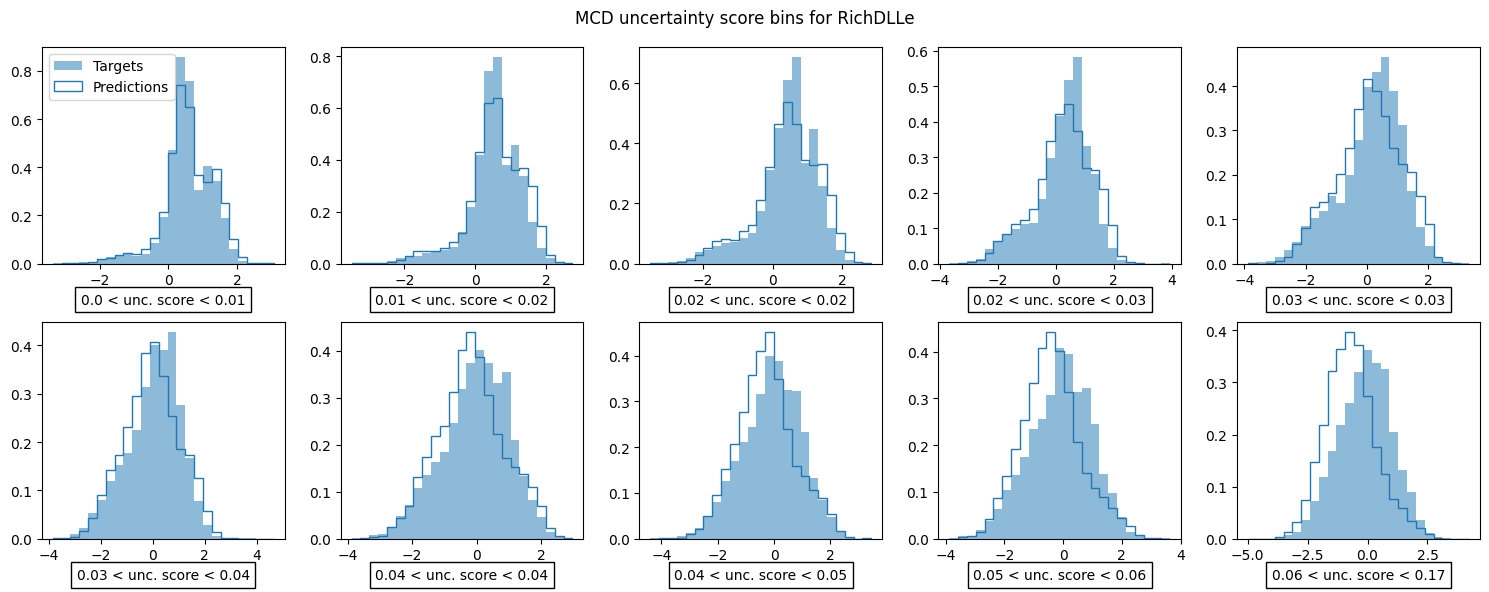

JS Distances:
0.06739856679354299, 0.0940685866887766, 0.10609134157230868, 0.10565553166848557, 0.1083766072177995, 0.10353981203786726, 0.10648495697437454, 0.11138439943785308, 0.14805072959963922, 0.21010808048736934
0.0 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.07: Number of observations: 10000
0.07 < unc. score < 0.09: Number of observations: 10000
0.09 < unc. score < 0.34: Number of observations: 9999


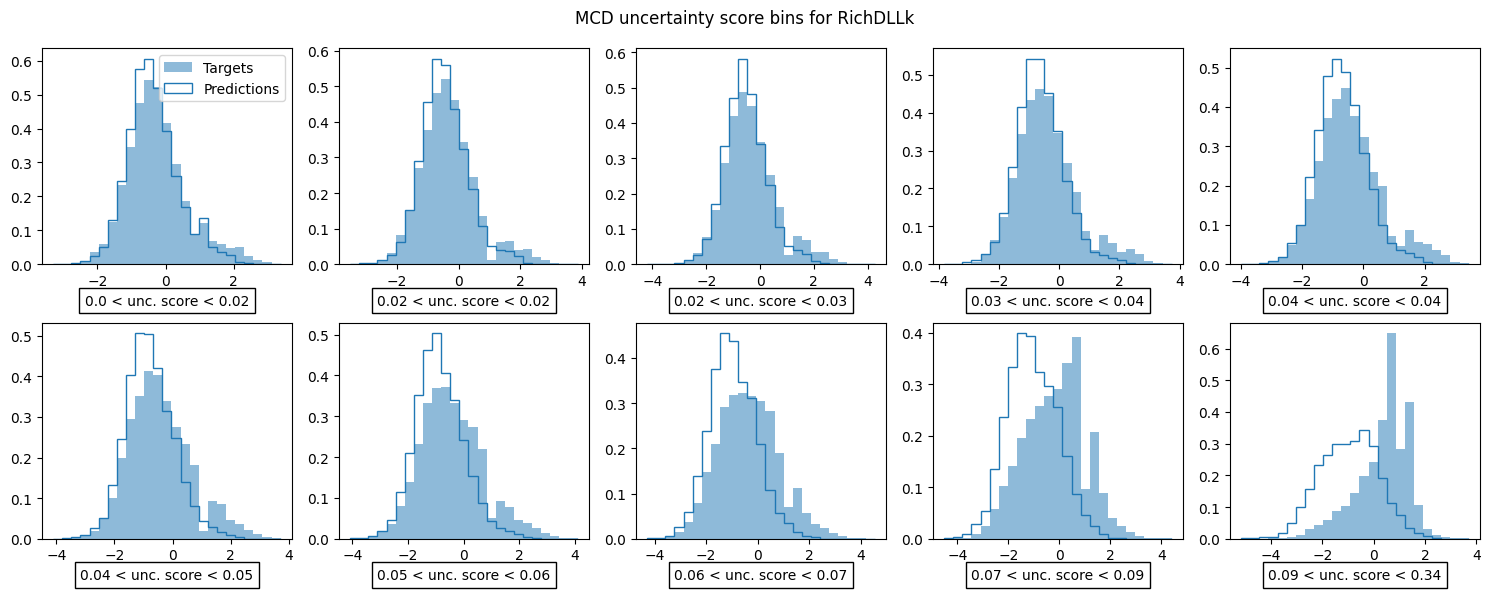

JS Distances:
0.08996183613435131, 0.10804735854780374, 0.11024393567580083, 0.12327397861757004, 0.1407901212173964, 0.16213714108720573, 0.17548776467132718, 0.2224131521328677, 0.29189917751157524, 0.4188068489058234
0.0 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.18: Number of observations: 9999


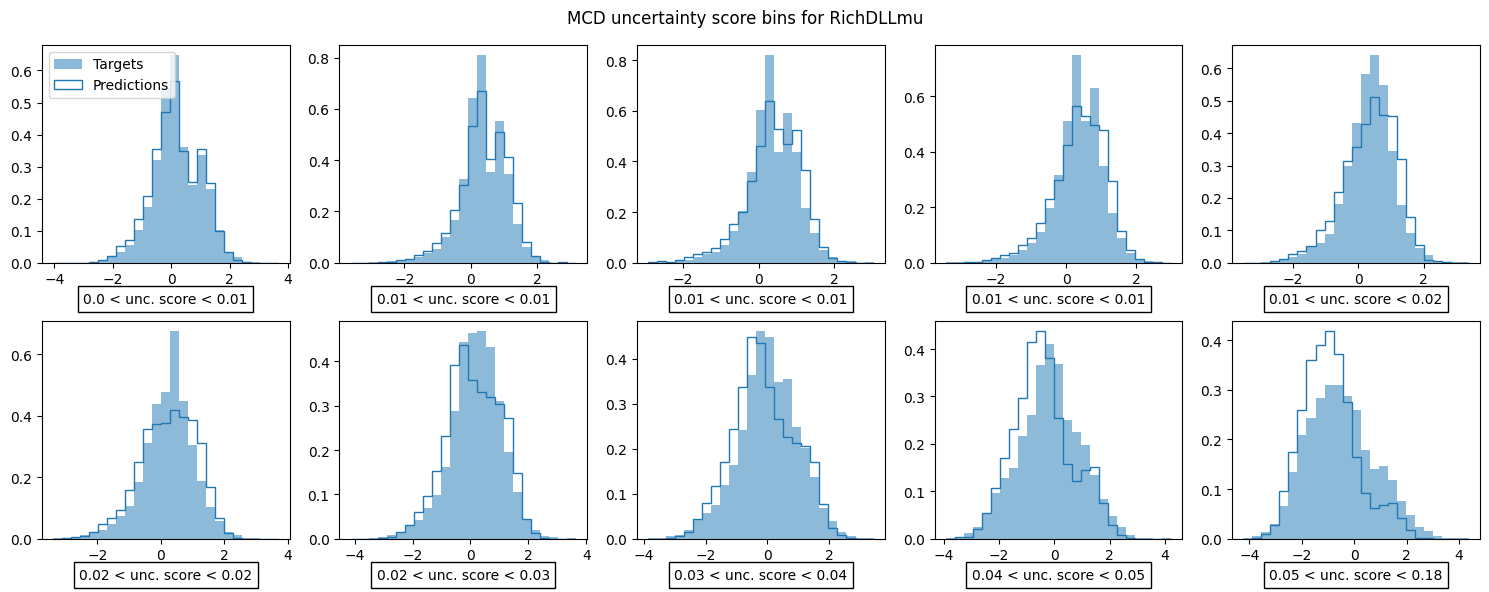

JS Distances:
0.05279073311502419, 0.07102800736725157, 0.09149187929744304, 0.08939814419624308, 0.10562582015125616, 0.11289434642697335, 0.10295860068571241, 0.10102912414415097, 0.12366866581252178, 0.153468281997768
0.0 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.07: Number of observations: 10000
0.07 < unc. score < 0.08: Number of observations: 10000
0.08 < unc. score < 0.09: Number of observations: 10000
0.09 < unc. score < 0.31: Number of observations: 9999


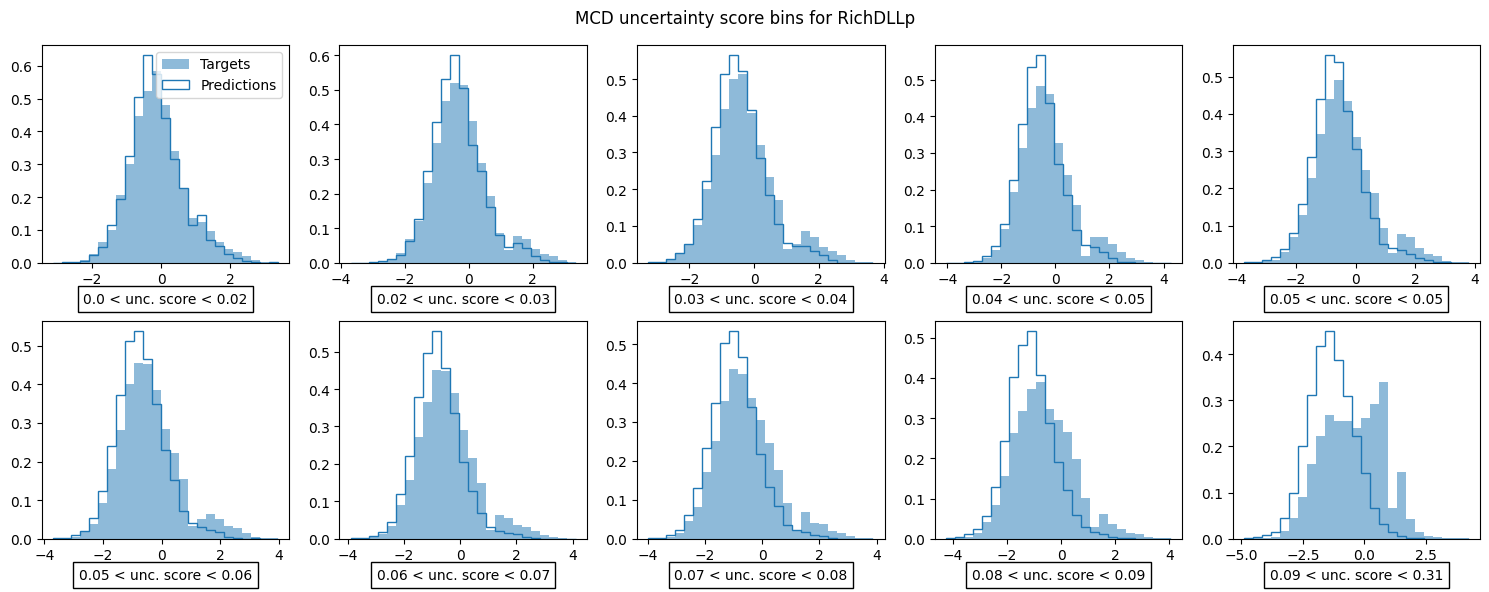

JS Distances:
0.06001275606637269, 0.07482070223878072, 0.09942659371622302, 0.11996593005831226, 0.11285489243223319, 0.13104984291540483, 0.14578182609911264, 0.15771677421079727, 0.19361116033639214, 0.30798708439401346
0.0 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.07: Number of observations: 10000
0.07 < unc. score < 0.08: Number of observations: 10000
0.08 < unc. score < 0.1: Number of observations: 10000
0.1 < unc. score < 0.12: Number of observations: 10000
0.12 < unc. score < 0.46: Number of observations: 9999


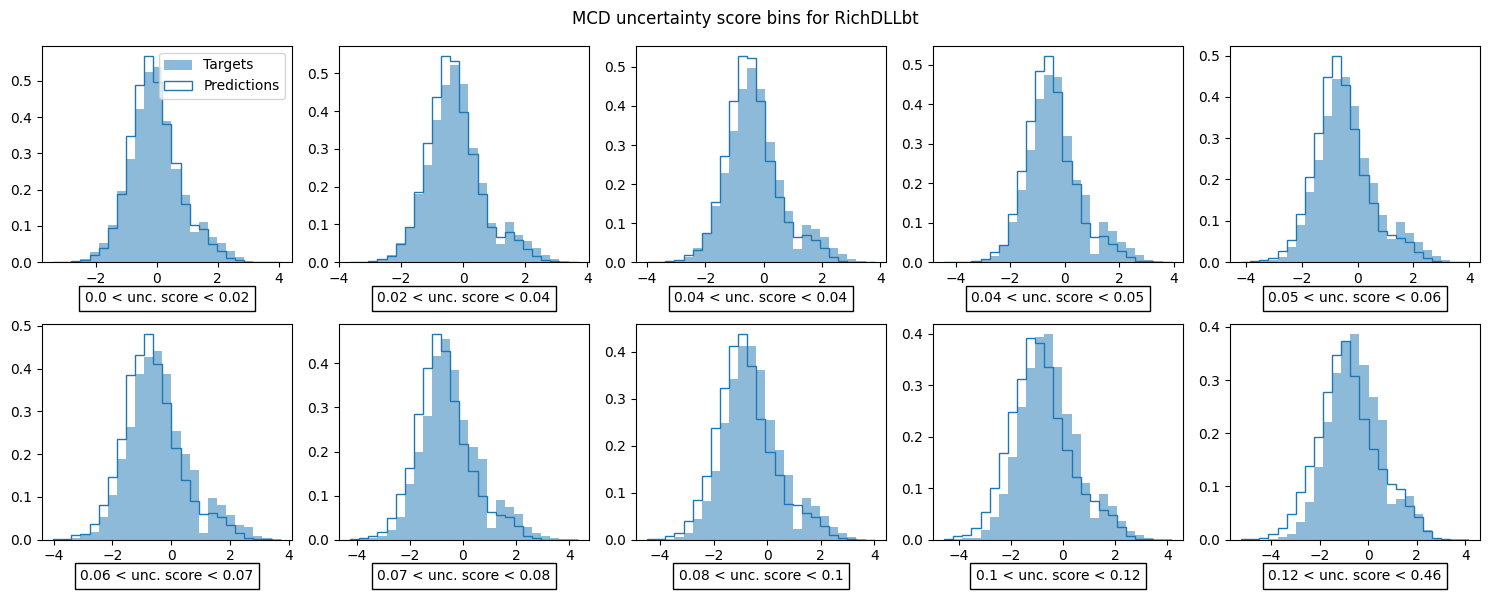

JS Distances:
0.06059304116706581, 0.06737568849364137, 0.08763842873427442, 0.1037140245963609, 0.09797284775873032, 0.11916834986860314, 0.13183499604346693, 0.135730198175054, 0.1369353633344536, 0.13923197012929198


In [ ]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

metric = 'JS'
#metric = 'KS'

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_final_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i, metric=metric)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: 0.962856708185521
Correlation coefficient for RichDLLk: 0.9551050410573204
Correlation coefficient for RichDLLmu: 0.8515990057982638
Correlation coefficient for RichDLLp: 0.9826798818033122
Correlation coefficient for RichDLLbt: 0.6655881457500141


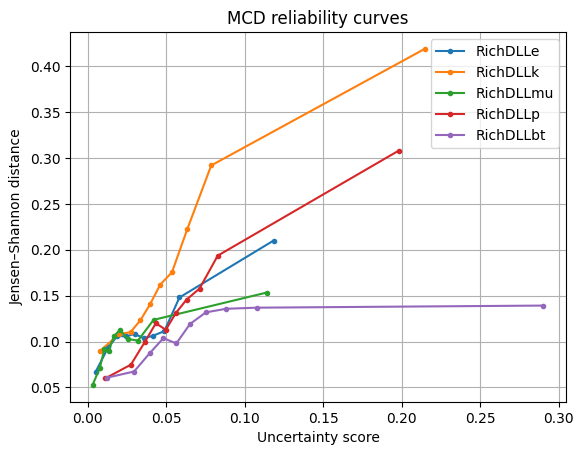

In [ ]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD', metric=metric)

#### KS / Quantile bins

0.0 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.17: Number of observations: 9999


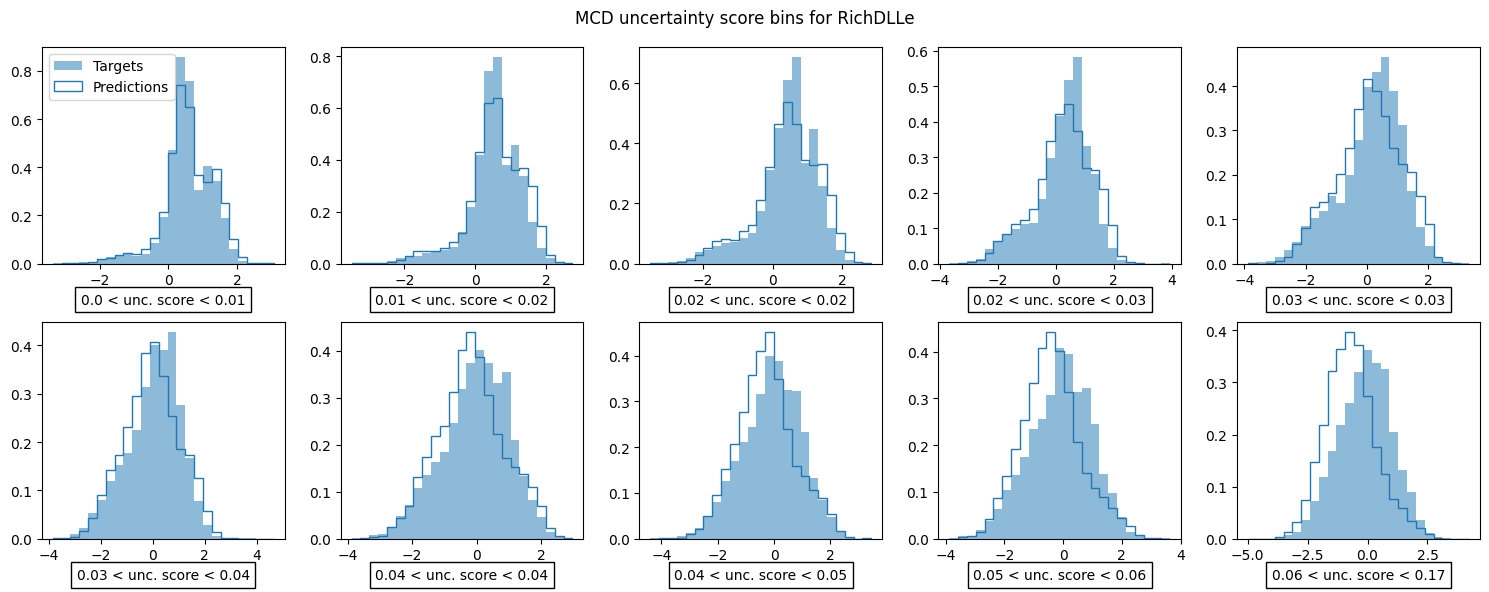

KS Distances:
0.0513, 0.0732, 0.0708, 0.0647, 0.0674, 0.0846, 0.1016, 0.1273, 0.1763, 0.2707270727072707
0.0 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.07: Number of observations: 10000
0.07 < unc. score < 0.09: Number of observations: 10000
0.09 < unc. score < 0.34: Number of observations: 9999


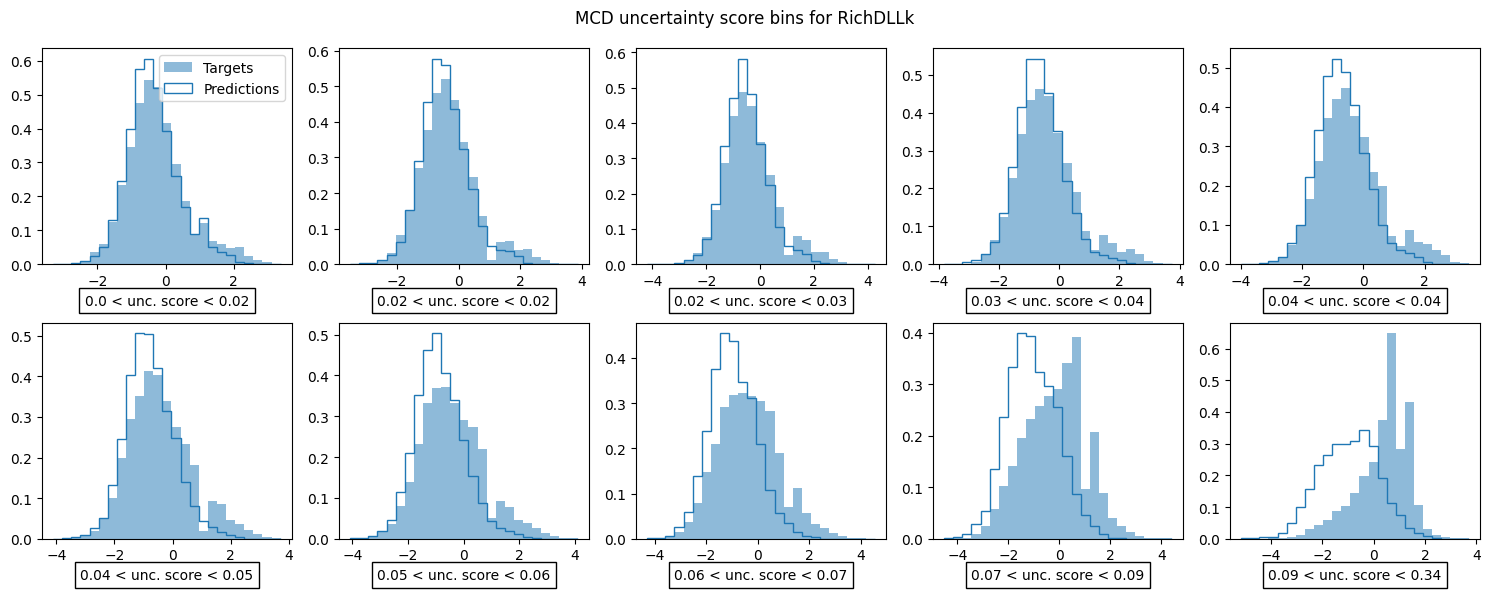

KS Distances:
0.0587, 0.0662, 0.0826, 0.1, 0.1258, 0.1458, 0.1823, 0.2372, 0.3317, 0.5183518351835184
0.0 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.01: Number of observations: 10000
0.01 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.18: Number of observations: 9999


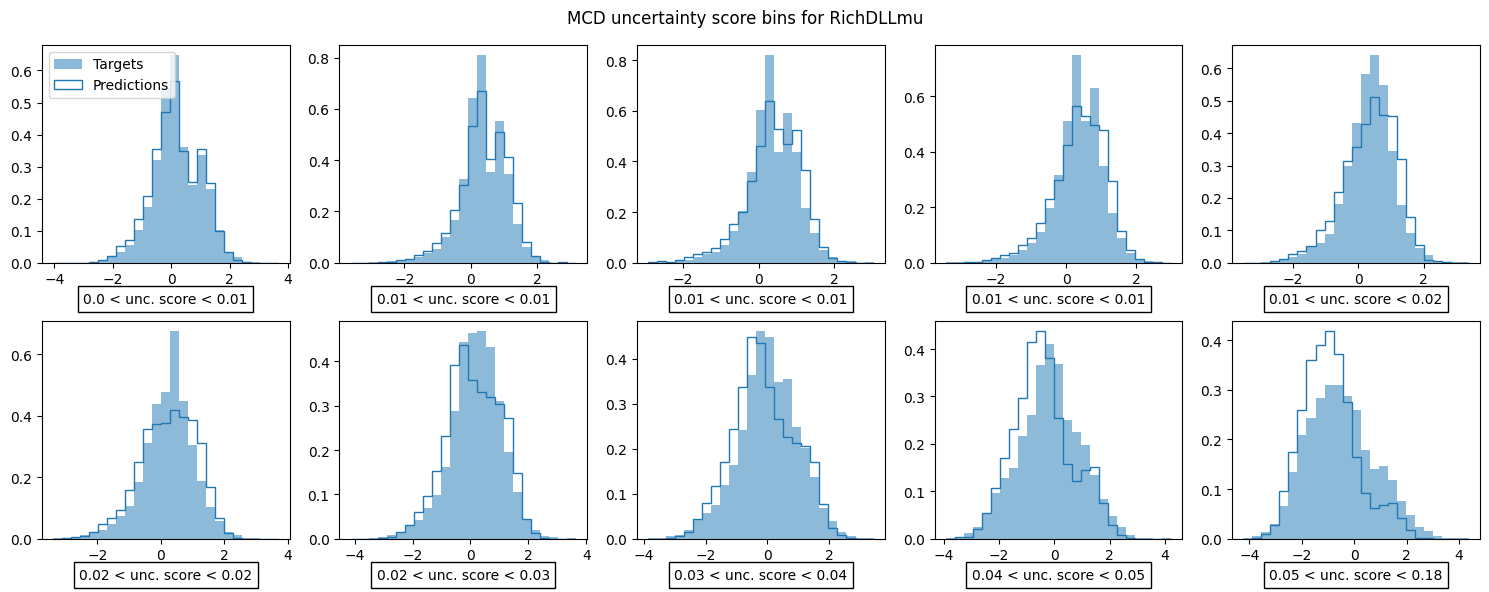

KS Distances:
0.0451, 0.0581, 0.0757, 0.0738, 0.0843, 0.076, 0.09, 0.11, 0.1479, 0.1767176717671767
0.0 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.03: Number of observations: 10000
0.03 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.07: Number of observations: 10000
0.07 < unc. score < 0.08: Number of observations: 10000
0.08 < unc. score < 0.09: Number of observations: 10000
0.09 < unc. score < 0.31: Number of observations: 9999


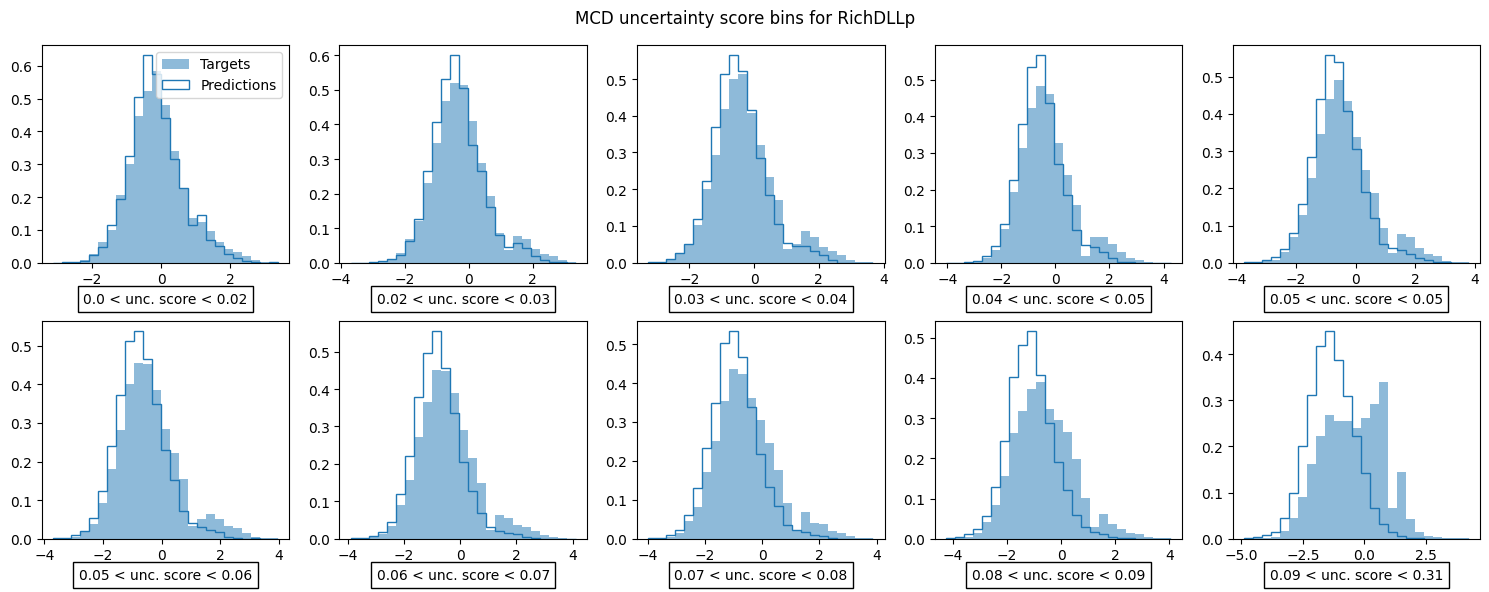

KS Distances:
0.046, 0.0688, 0.0848, 0.1093, 0.1162, 0.1294, 0.1567, 0.1706, 0.2162, 0.34233423342334235
0.0 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.04: Number of observations: 10000
0.04 < unc. score < 0.05: Number of observations: 10000
0.05 < unc. score < 0.06: Number of observations: 10000
0.06 < unc. score < 0.07: Number of observations: 10000
0.07 < unc. score < 0.08: Number of observations: 10000
0.08 < unc. score < 0.1: Number of observations: 10000
0.1 < unc. score < 0.12: Number of observations: 10000
0.12 < unc. score < 0.46: Number of observations: 9999


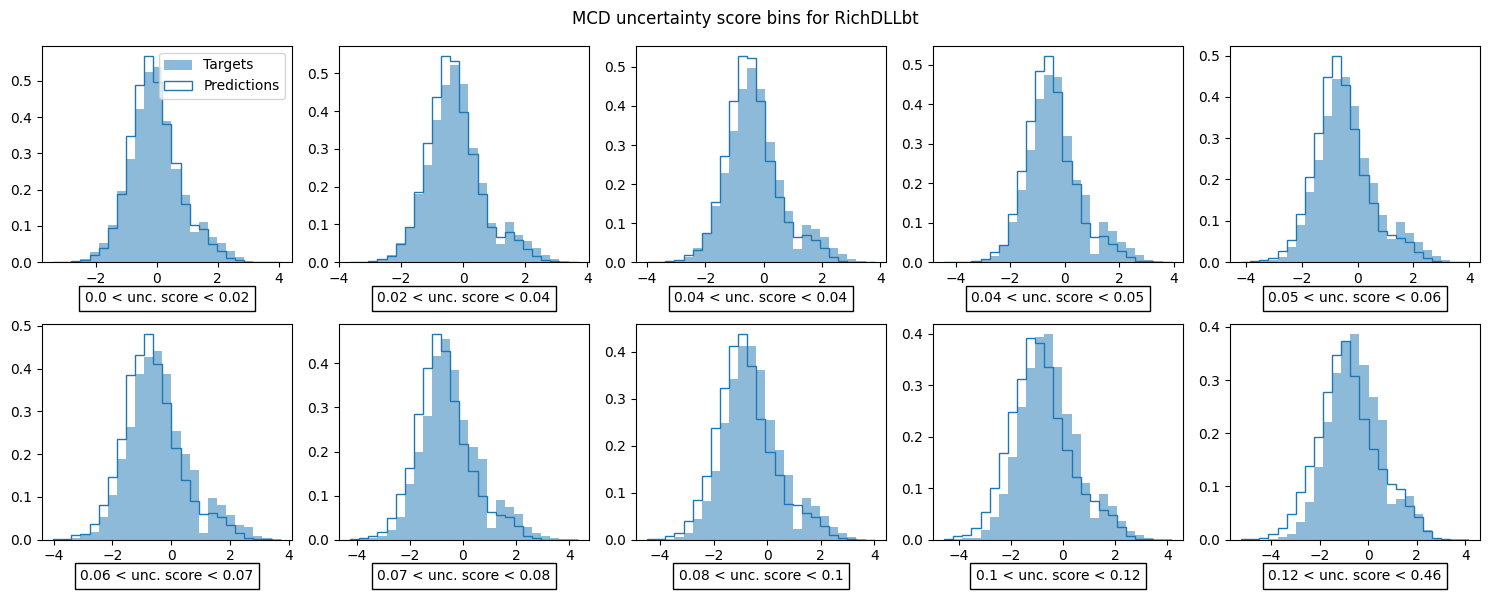

KS Distances:
0.0409, 0.0654, 0.0806, 0.0931, 0.1074, 0.1163, 0.1351, 0.1359, 0.146, 0.13031303130313032


In [ ]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

# metric = 'JS'
metric = 'KS'

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_final_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i, metric=metric)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: 0.97038647276498
Correlation coefficient for RichDLLk: 0.9581469438937888
Correlation coefficient for RichDLLmu: 0.9117591647693591
Correlation coefficient for RichDLLp: 0.9758061141405108
Correlation coefficient for RichDLLbt: 0.5754176727893728


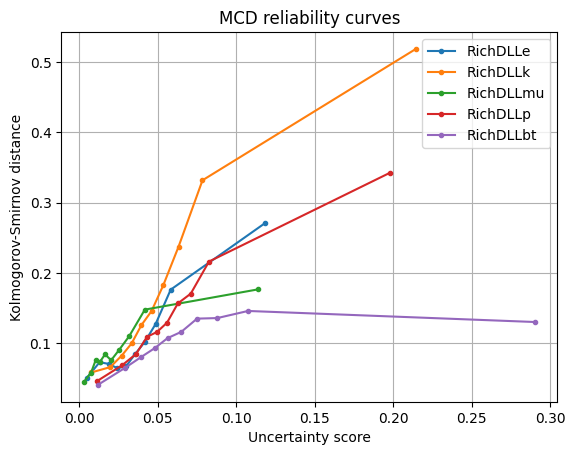

In [ ]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD', metric=metric)

## Feature Densities method

### Generation of FD embeddings

In [ ]:
# from feature_densities.feature_density_evaluator import create_embeddings_model
# embeddings_model = create_embeddings_model(model)
# train_embeddings, train_predictions = embeddings_model.predict(dataset['feats_train'])
# test_embeddings, test_predictions = embeddings_model.predict(dataset['feats_val'])

# !rm -r embeddings
# !mkdir embeddings

# np.save(embeddings_dir + f'{PARTICLE}_train_embeddings.npy', train_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_train_predictions.npy', train_predictions)
# np.save(embeddings_dir + f'{PARTICLE}_test_embeddings.npy', test_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_test_predictions.npy', test_predictions)

### Uncertainty estimation

In [ ]:
train_embeddings = np.load(embeddings_dir + f'{PARTICLE}_train_embeddings.npy')
train_embeddings.shape

(948325, 128)

In [ ]:
%%time

fd_uncertainties = []
kde_max = get_kde_max(train_embeddings, n_samples=100, kde_max_resolution=10000, n_features=128)


for i in range(30):
  print(f'Run {i + 1}')
  fd_unc, _ = fd_evaluate_model(model, x_sample, kde_max, likelihood_method='normalized',
                                known_embeddings=train_embeddings,embedding_layer=14)
  fd_uncertainties.append(fd_unc)


Run 1
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:27<00:00,  4.60it/s]


Run 2
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:28<00:00,  4.42it/s]


Run 3
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.75it/s]


Run 4
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:27<00:00,  4.63it/s]


Run 5
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.76it/s]


Run 6
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.77it/s]


Run 7
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:27<00:00,  4.74it/s]


Run 8
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.78it/s]


Run 9
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.74it/s]


Run 10
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.77it/s]


Run 11
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.77it/s]


Run 12
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.81it/s]


Run 13
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.77it/s]


Run 14
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.79it/s]


Run 15
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.77it/s]


Run 16
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.79it/s]


Run 17
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:27<00:00,  4.58it/s]


Run 18
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.76it/s]


Run 19
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:27<00:00,  4.61it/s]


Run 20
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:27<00:00,  4.69it/s]


Run 21
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:28<00:00,  4.41it/s]


Run 22
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.77it/s]


Run 23
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.78it/s]


Run 24
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.77it/s]


Run 25
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:27<00:00,  4.62it/s]


Run 26
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:27<00:00,  4.73it/s]


Run 27
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:27<00:00,  4.70it/s]


Run 28
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.75it/s]


Run 29
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:27<00:00,  4.71it/s]


Run 30
Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:26<00:00,  4.74it/s]

CPU times: user 5h 2min 13s, sys: 27.3 s, total: 5h 2min 41s
Wall time: 17min 56s


In [ ]:
stacked_fd_uncertainty = tf.stack(fd_uncertainties)
fd_uncertainty_normalized = tf.reduce_mean(stacked_fd_uncertainty, axis=0)

print('Feature Densities using NORMALIZED uncertainty score for x_sample:')
fd_uncertainty_normalized.shape

Feature Densities using NORMALIZED uncertainty score for x_sample:


TensorShape([100000])

In [ ]:
# Save FD uncertainties normalized
np.save(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy', fd_uncertainty_normalized)

### Plot FD uncertainties

#### JS / Quantile bins

0.14 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.94: Number of observations: 9999


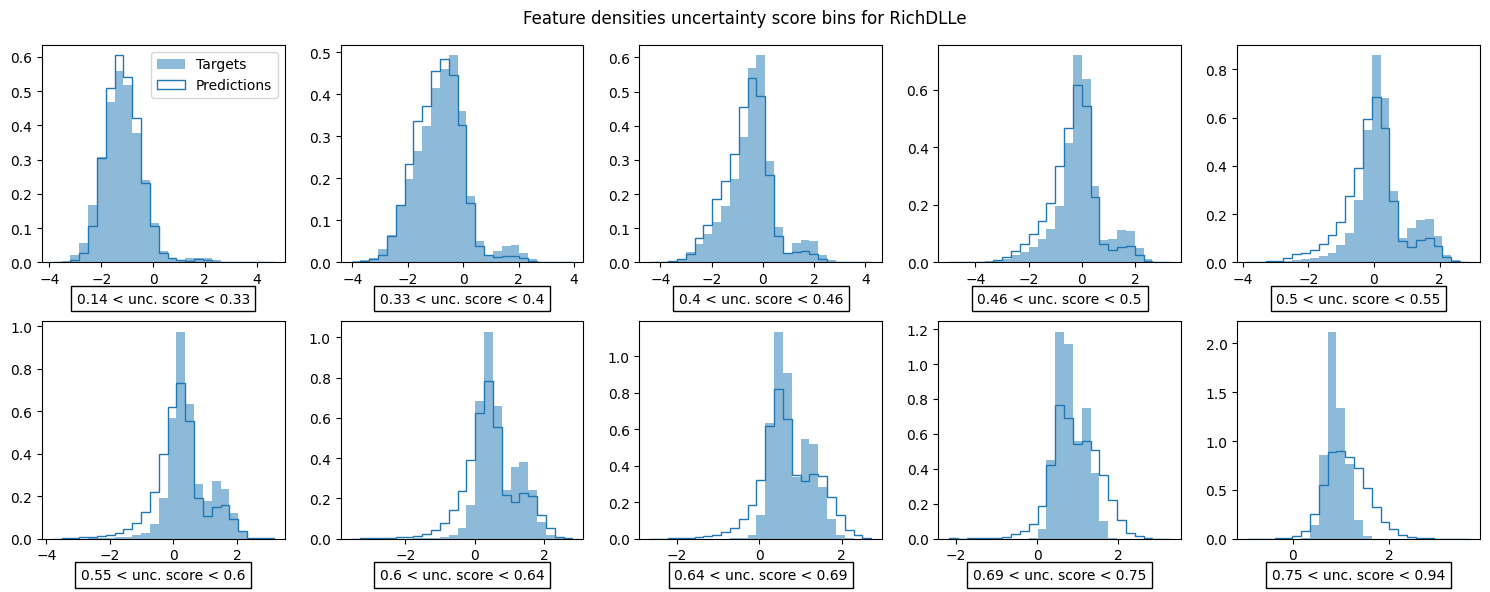

JS Distances:
0.06556162383128593, 0.07534833661144608, 0.10111652847057506, 0.12851393705861933, 0.15931216134573564, 0.18195818022081556, 0.2101757301074601, 0.2227758164597024, 0.25224385270843613, 0.347261839837074
0.14 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.94: Number of observations: 9999


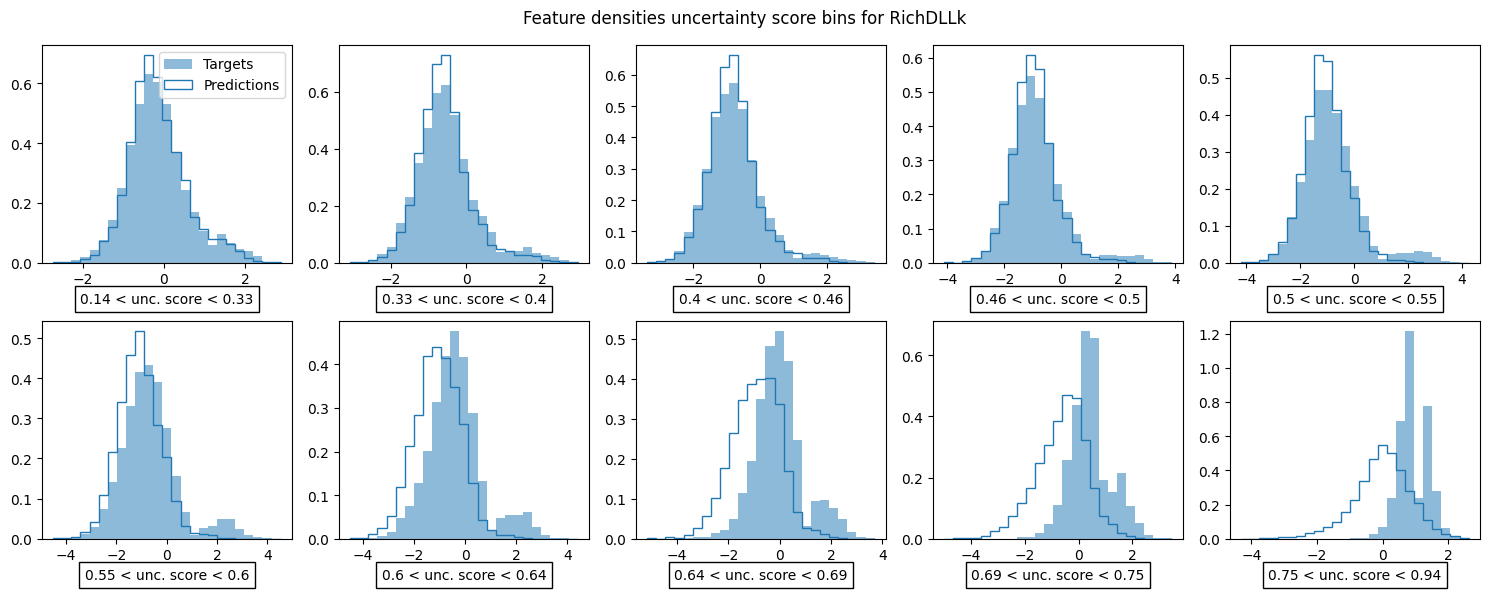

JS Distances:
0.05731990183521119, 0.07725281061424634, 0.07862181616780538, 0.09584043242128175, 0.12574704429880673, 0.17326969167471165, 0.2528804127279996, 0.32997030018412055, 0.4216374987599155, 0.5087751622486343
0.14 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.94: Number of observations: 9999


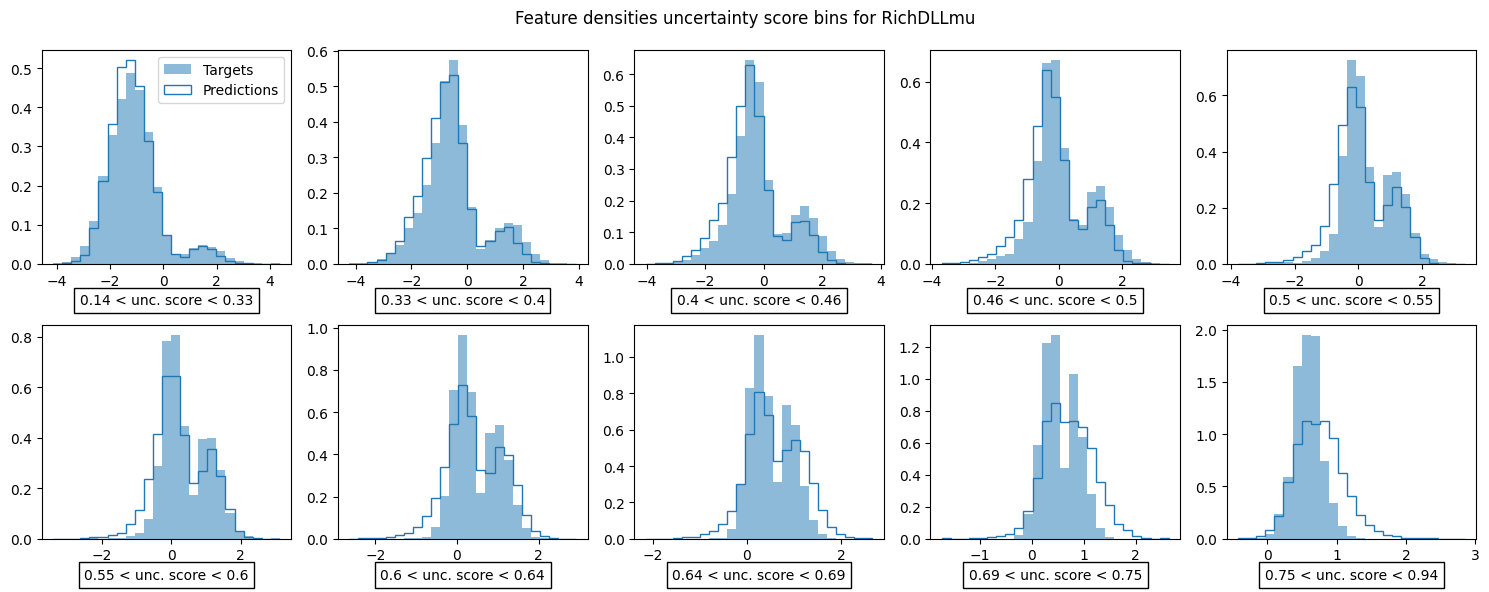

JS Distances:
0.06356070142269703, 0.08794472578666786, 0.1201870003057696, 0.13229185439630736, 0.14803878512530663, 0.1468987417649635, 0.17544037251742858, 0.19586917945762783, 0.23334311486074047, 0.28941897856090704
0.14 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.94: Number of observations: 9999


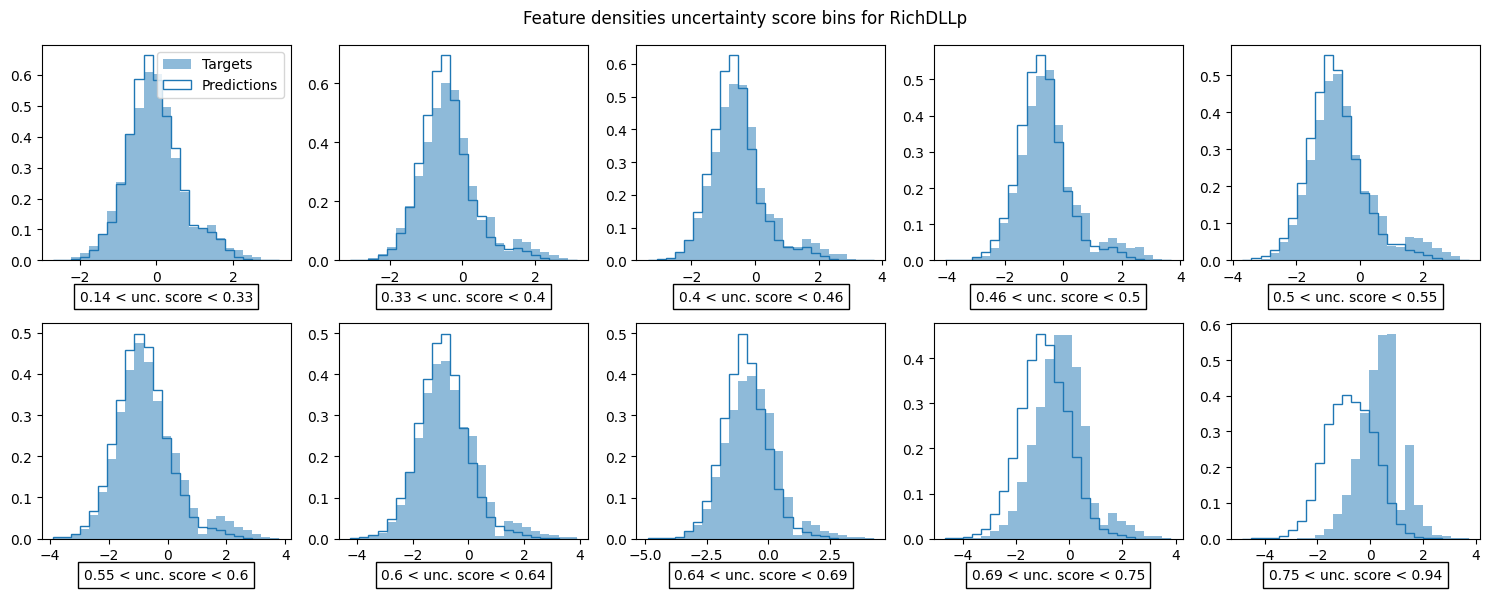

JS Distances:
0.058805495002537206, 0.09048374391705899, 0.09881361605534342, 0.11304578095359658, 0.10841154804090329, 0.10130480060843894, 0.1090115968821273, 0.1296084990449095, 0.23240925936397858, 0.4343311420469986
0.14 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.94: Number of observations: 9999


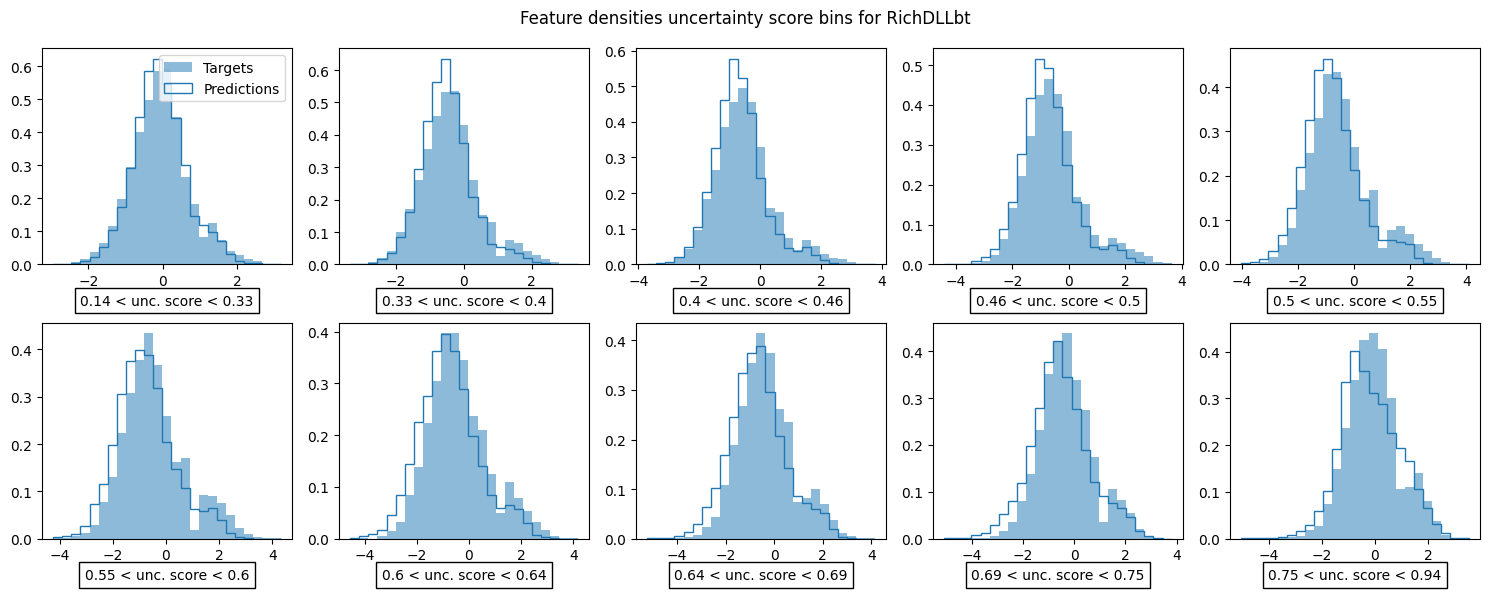

JS Distances:
0.06331646067322186, 0.09444191617021161, 0.09622563510682577, 0.10854971974860439, 0.12318226759233437, 0.13136659430545006, 0.13068663003694111, 0.1264885192568164, 0.12414611712471363, 0.1196015078082987


In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

metric = 'JS'
#metric = 'KS'

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i, metric=metric)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.9748846559539875
Correlation coefficient for RichDLLk: 0.9267331761763884
Correlation coefficient for RichDLLmu: 0.9793265500401902
Correlation coefficient for RichDLLp: 0.7894252999968083
Correlation coefficient for RichDLLbt: 0.813592110505086


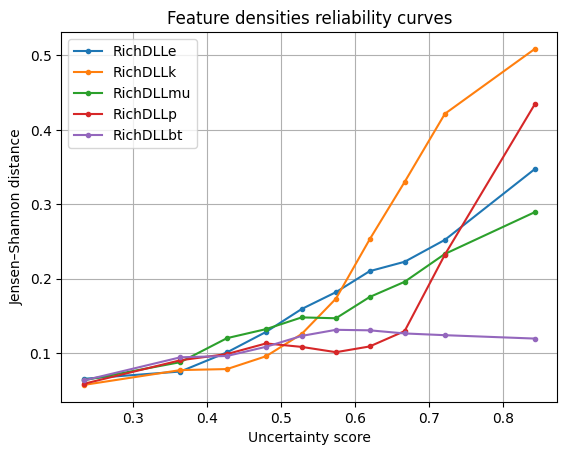

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities', metric=metric)

#### KS / Quantile bins

0.14 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.94: Number of observations: 9999


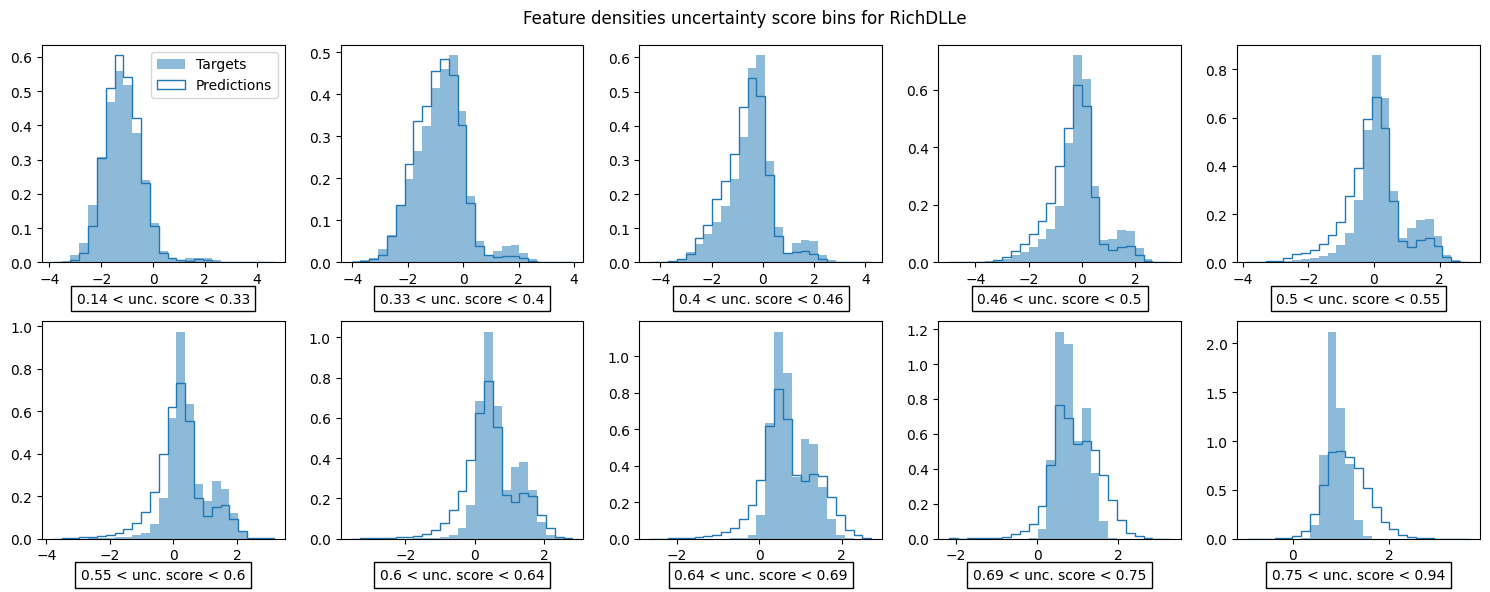

KS Distances:
0.0447, 0.0621, 0.1185, 0.1482, 0.1787, 0.1929, 0.1887, 0.1414, 0.168, 0.33813381338133813
0.14 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.94: Number of observations: 9999


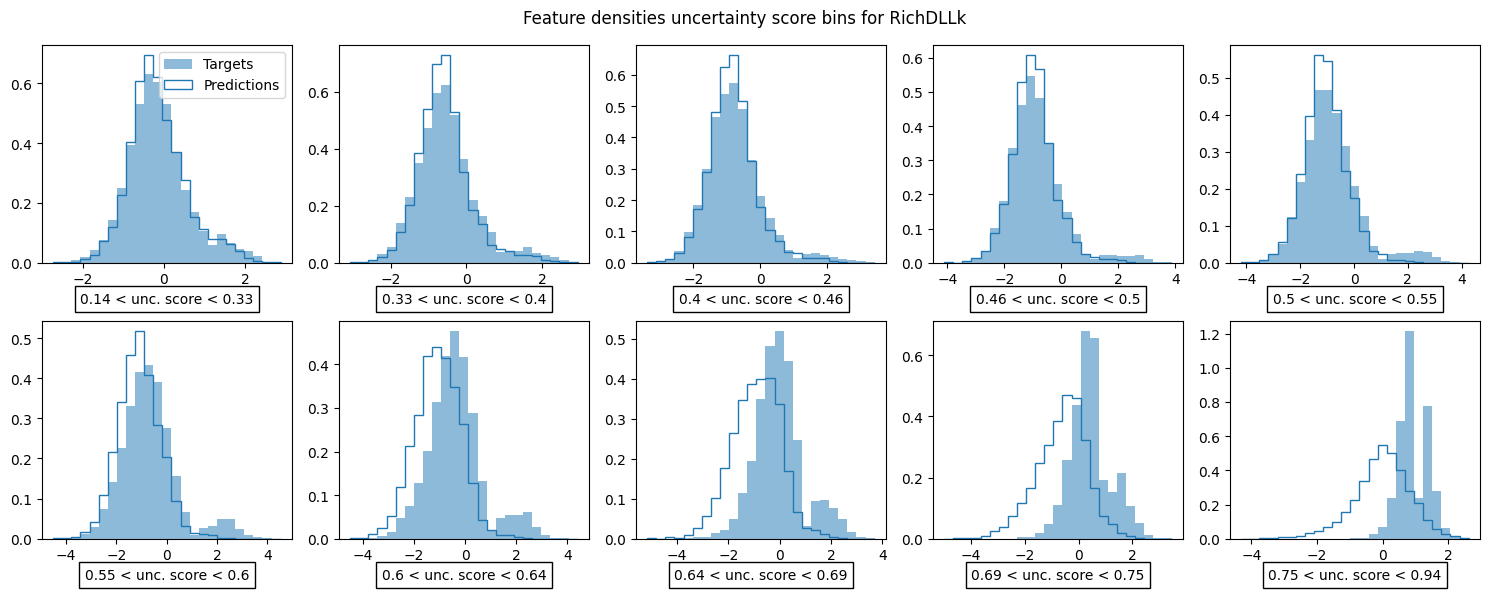

KS Distances:
0.0213, 0.06, 0.0515, 0.0578, 0.0967, 0.1787, 0.2822, 0.3632, 0.4934, 0.603060306030603
0.14 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.94: Number of observations: 9999


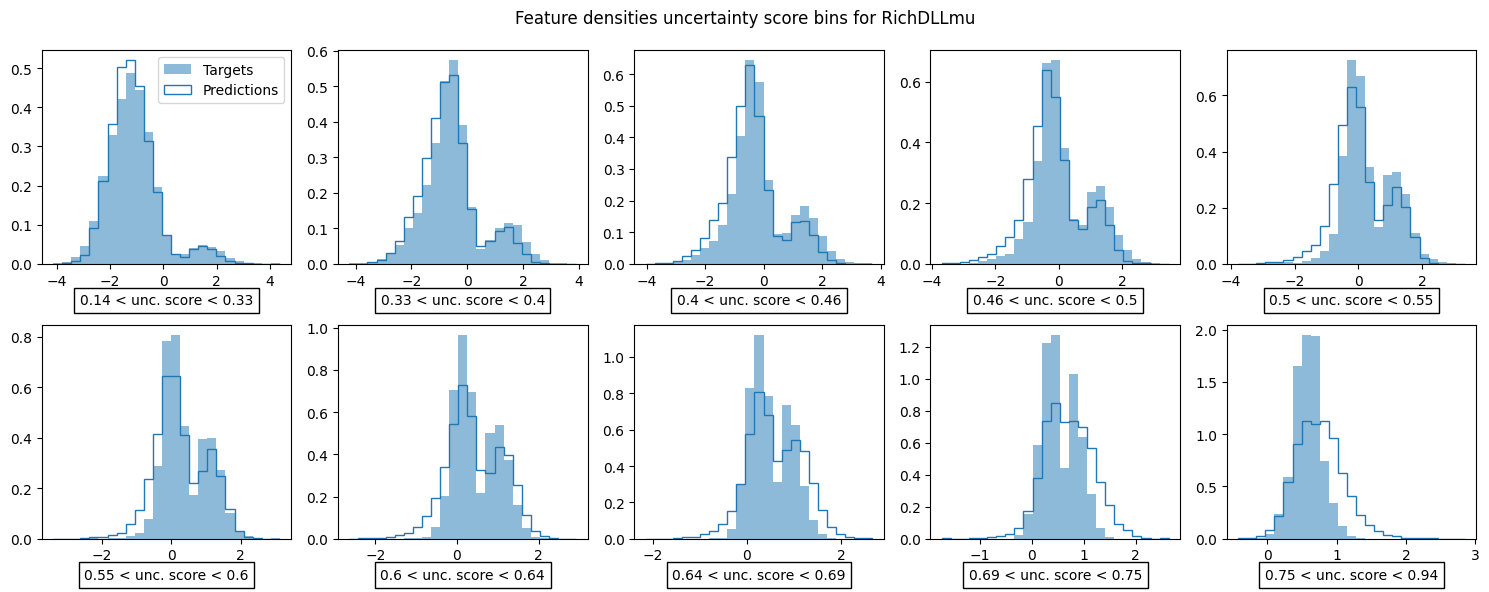

KS Distances:
0.0306, 0.0808, 0.134, 0.1345, 0.1431, 0.1256, 0.1074, 0.1216, 0.1804, 0.3163316331633163
0.14 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.94: Number of observations: 9999


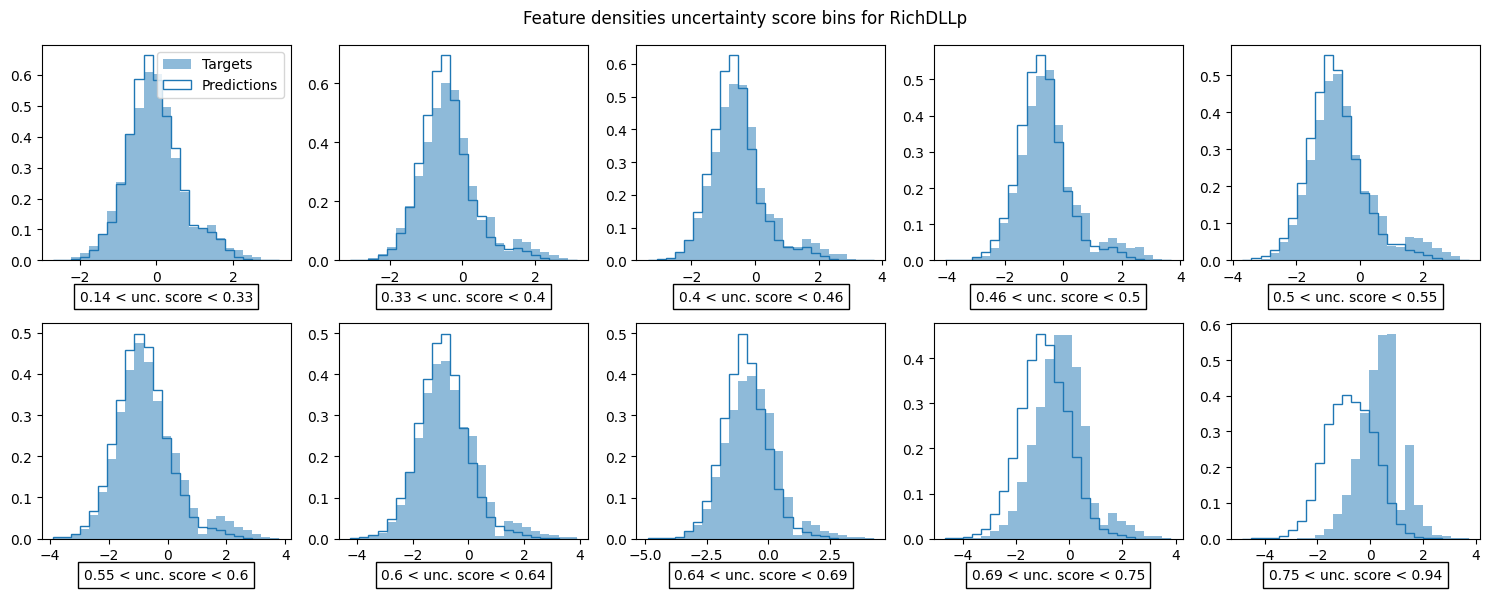

KS Distances:
0.0231, 0.084, 0.0997, 0.0986, 0.089, 0.0752, 0.0888, 0.1344, 0.2798, 0.504050405040504
0.14 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.6: Number of observations: 10000
0.6 < unc. score < 0.64: Number of observations: 10000
0.64 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.75: Number of observations: 10000
0.75 < unc. score < 0.94: Number of observations: 9999


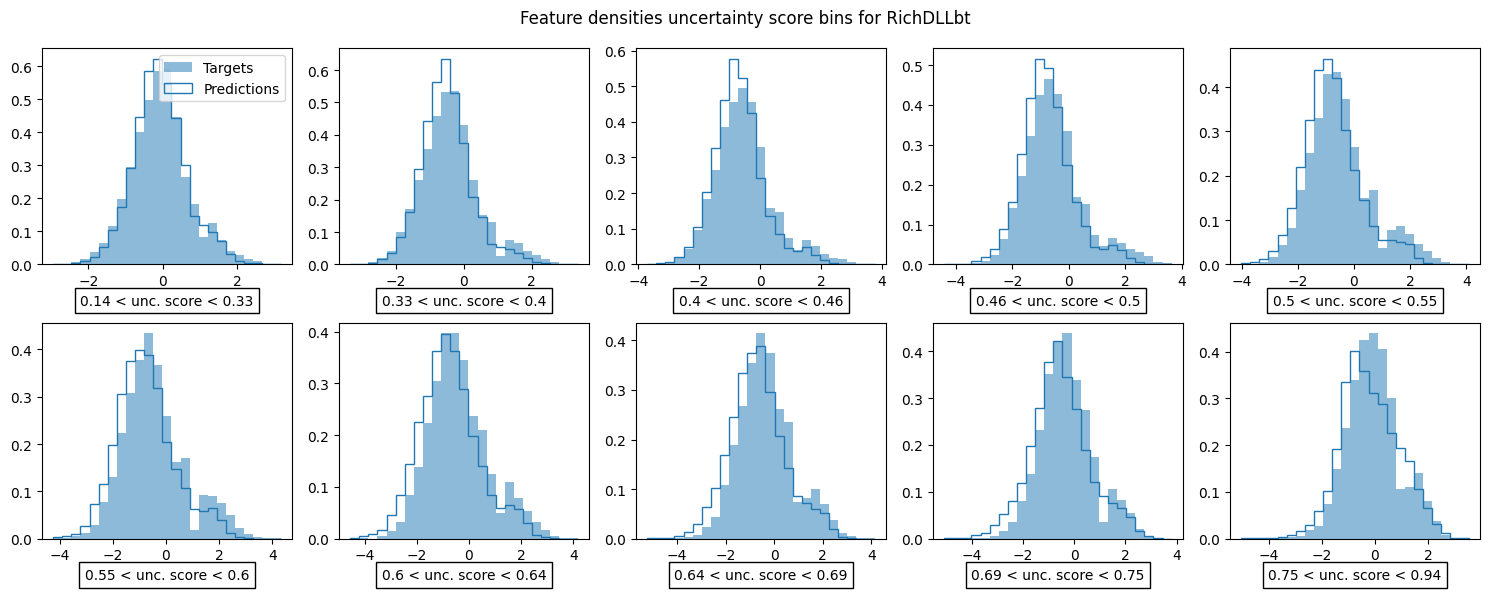

KS Distances:
0.0247, 0.0834, 0.1018, 0.1119, 0.1205, 0.1205, 0.1342, 0.1306, 0.1143, 0.10231023102310231


In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

# metric = 'JS'
metric = 'KS'

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i, metric=metric)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.8739245957979291
Correlation coefficient for RichDLLk: 0.9216401632319418
Correlation coefficient for RichDLLmu: 0.8359016527608365
Correlation coefficient for RichDLLp: 0.7928907772707648
Correlation coefficient for RichDLLbt: 0.6875030318085384


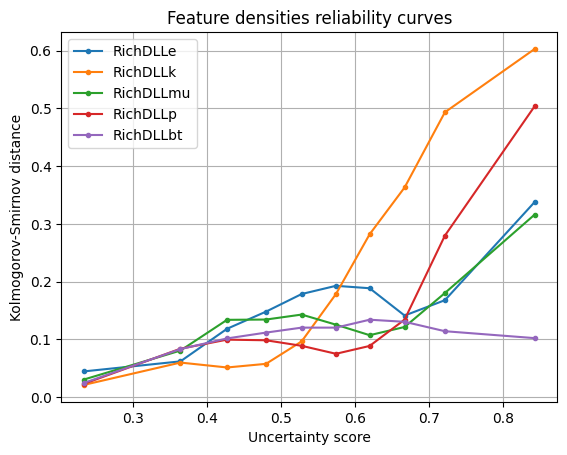

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities', metric=metric)

## Experiment 30x30

Load Results

In [ ]:
!unzip -qq '/content/drive/MyDrive/cern/data/results/30x30/pion_uncertainty_30x30_reps.zip'
!unzip -qq '/content/drive/MyDrive/cern/data/results/30x30/pion_sample_30x30.zip'

In [ ]:
y_sample = np.load('/content/results/pion_y_real.npy')
x_sample = np.load('/content/results/pion_x_real.npy')

y_sample_orig = np.load('/content/results/pion_y_real_orig.npy')
x_sample_orig = np.load('/content/results/pion_x_real_orig.npy')



t_generated = np.load('/content/results/t_generated.npy')

fd_uncertainty_normalized = np.load('/content/pion_fd_uncertainties_30_times.npy')
mcd_uncertainty = np.load('/content/pion_mcd_uncertainty_30_reps.npy')

fd_uncertainty_normalized = tf.reduce_mean(fd_uncertainty_normalized, axis=0)
mcd_uncertainty = tf.reduce_mean(mcd_uncertainty, axis=0)


fd_uncertainty_normalized.shape, mcd_uncertainty.shape

### FD using JS

0.165 < unc. score < 0.329: Number of observations: 10000
0.329 < unc. score < 0.399: Number of observations: 10000
0.399 < unc. score < 0.455: Number of observations: 10000
0.455 < unc. score < 0.504: Number of observations: 10000
0.504 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.596: Number of observations: 10000
0.596 < unc. score < 0.642: Number of observations: 10000
0.642 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.751: Number of observations: 10000
0.751 < unc. score < 0.934: Number of observations: 9999
JS Distances:
0.060920396647746046, 0.06937222321918106, 0.1068979308746563, 0.13718638077128312, 0.15896449986746122, 0.18480790988128484, 0.2157681471633917, 0.22987701805064314, 0.2507695494445344, 0.3460423969411876
0.165 < unc. score < 0.329: Number of observations: 10000
0.329 < unc. score < 0.399: Number of observations: 10000
0.399 < unc. score < 0.455: Number of observations: 10000
0.455 < unc. score < 0.504: Num

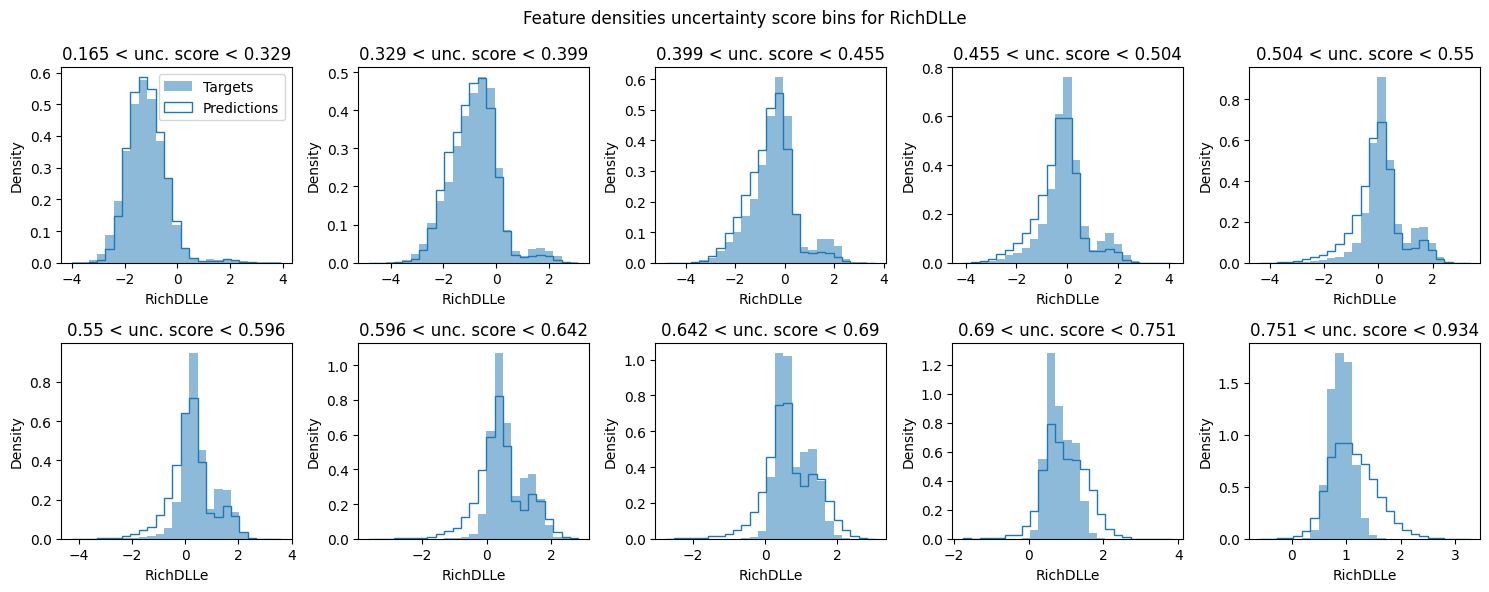

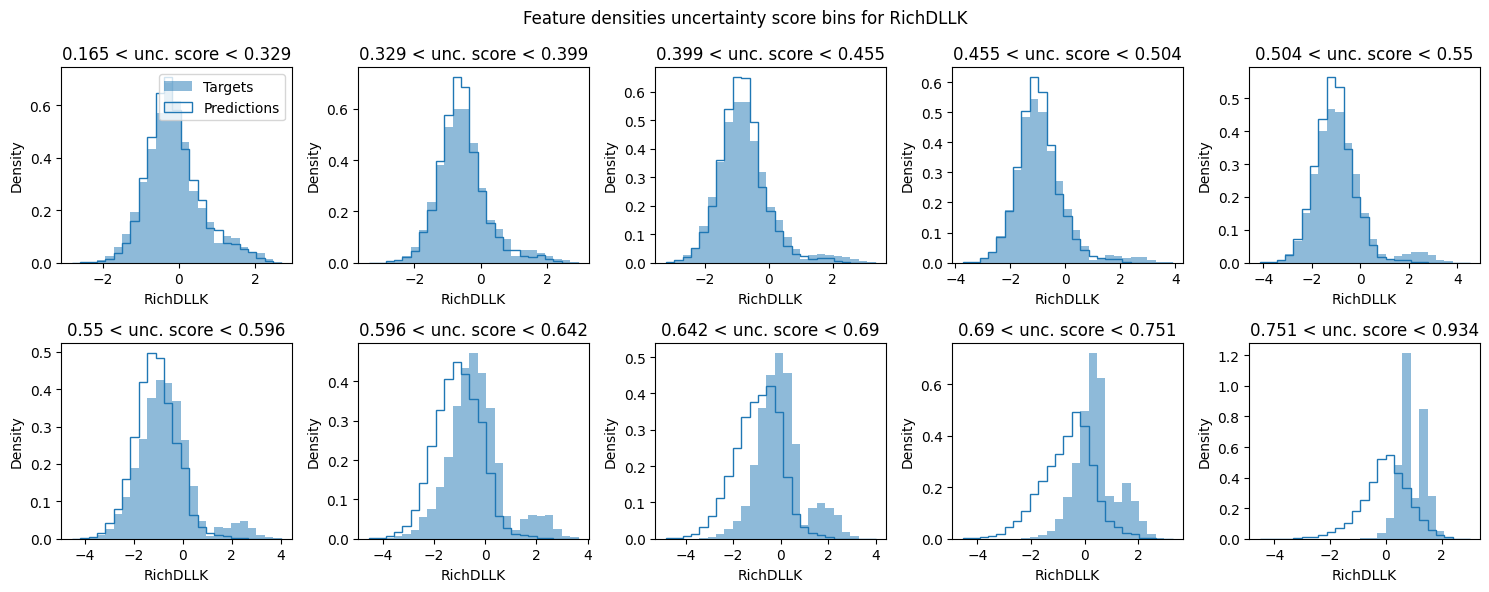

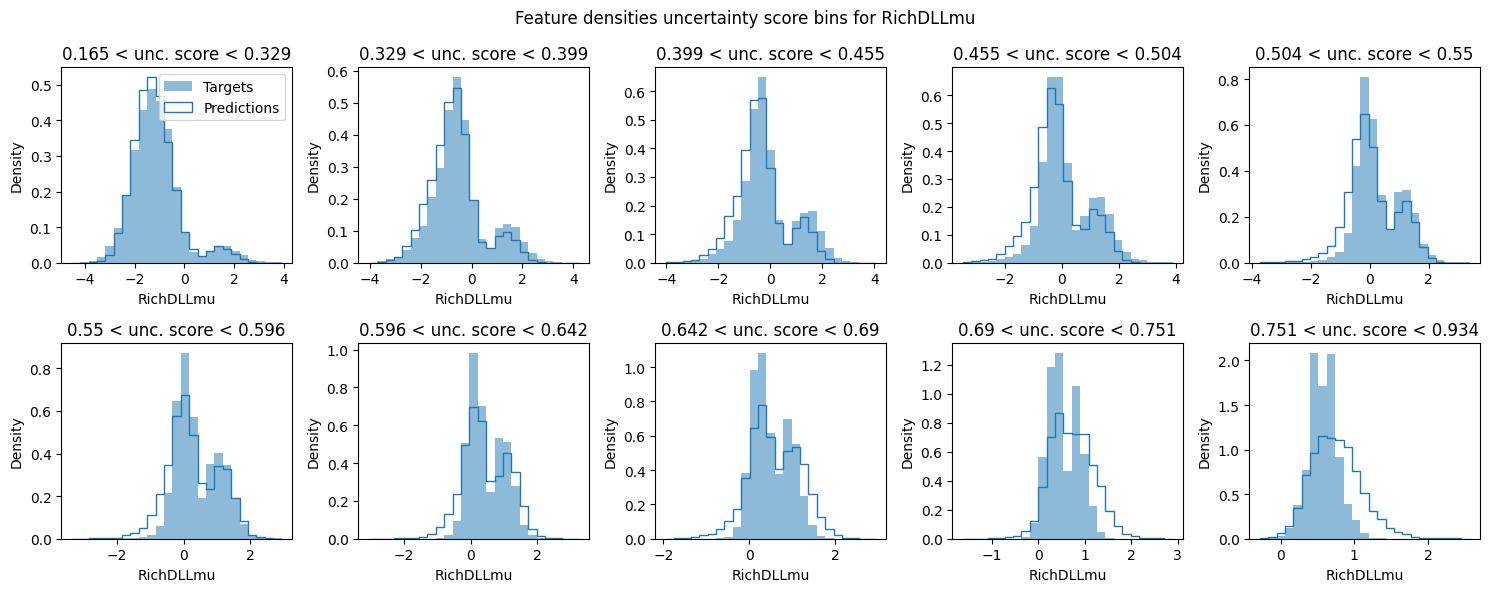

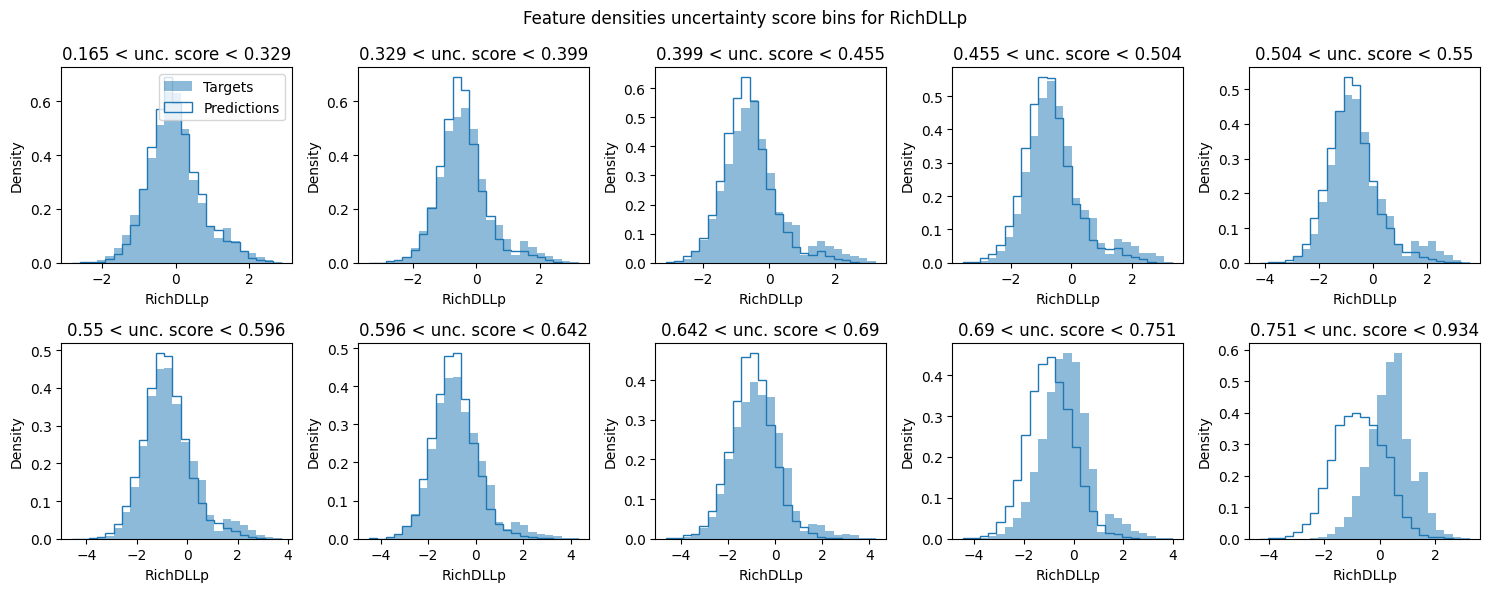

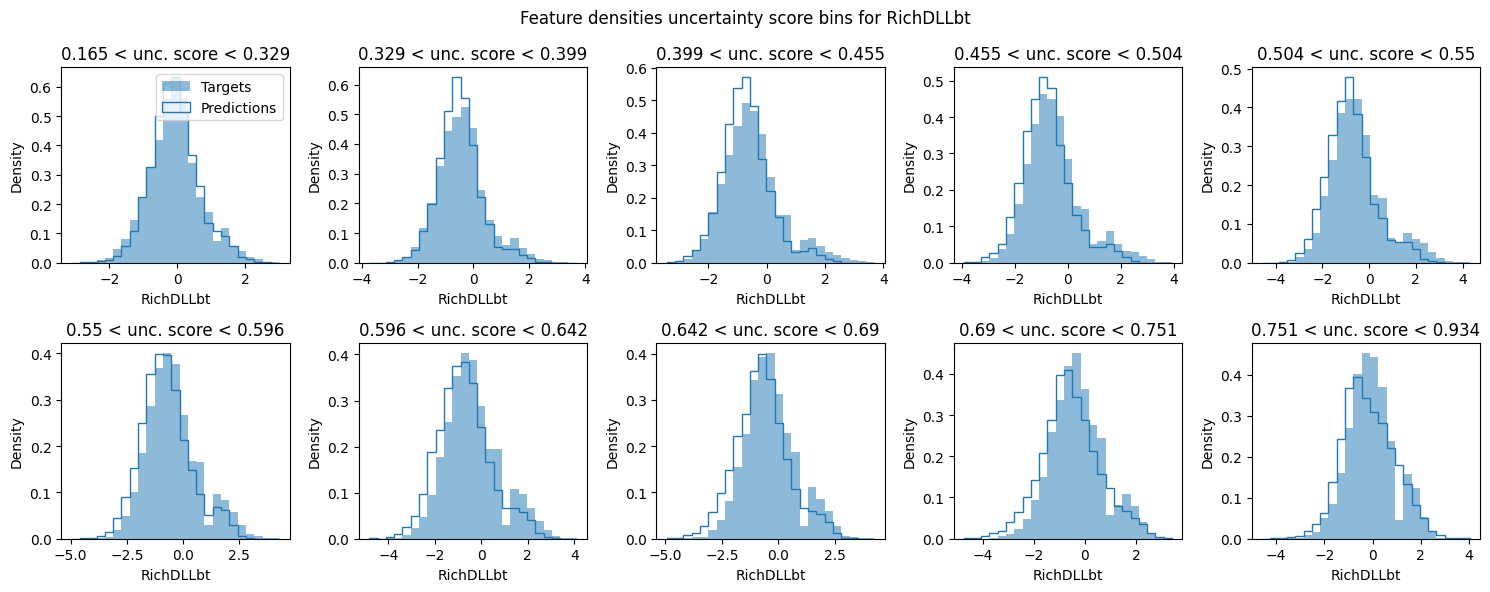

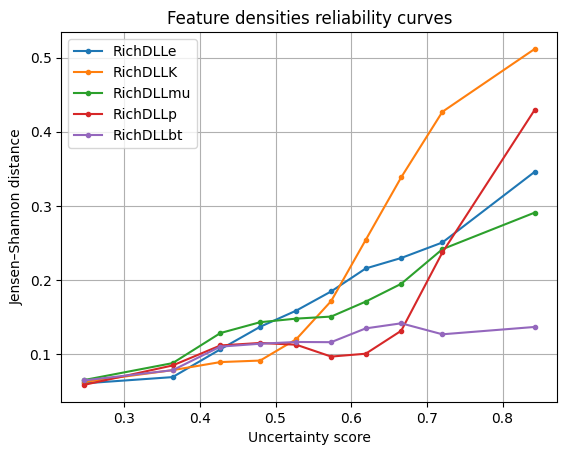

In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

metric = 'JS'
#metric = 'KS'

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i, metric=metric)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities', metric=metric)

### FD using KS

0.165 < unc. score < 0.329: Number of observations: 10000
0.329 < unc. score < 0.399: Number of observations: 10000
0.399 < unc. score < 0.455: Number of observations: 10000
0.455 < unc. score < 0.504: Number of observations: 10000
0.504 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.596: Number of observations: 10000
0.596 < unc. score < 0.642: Number of observations: 10000
0.642 < unc. score < 0.69: Number of observations: 10000
0.69 < unc. score < 0.751: Number of observations: 10000
0.751 < unc. score < 0.934: Number of observations: 9999
KS Distances:
0.0383, 0.052, 0.1111, 0.1581, 0.1877, 0.1921, 0.1895, 0.1573, 0.1773, 0.33363336333633364
0.165 < unc. score < 0.329: Number of observations: 10000
0.329 < unc. score < 0.399: Number of observations: 10000
0.399 < unc. score < 0.455: Number of observations: 10000
0.455 < unc. score < 0.504: Number of observations: 10000
0.504 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.596: Numb

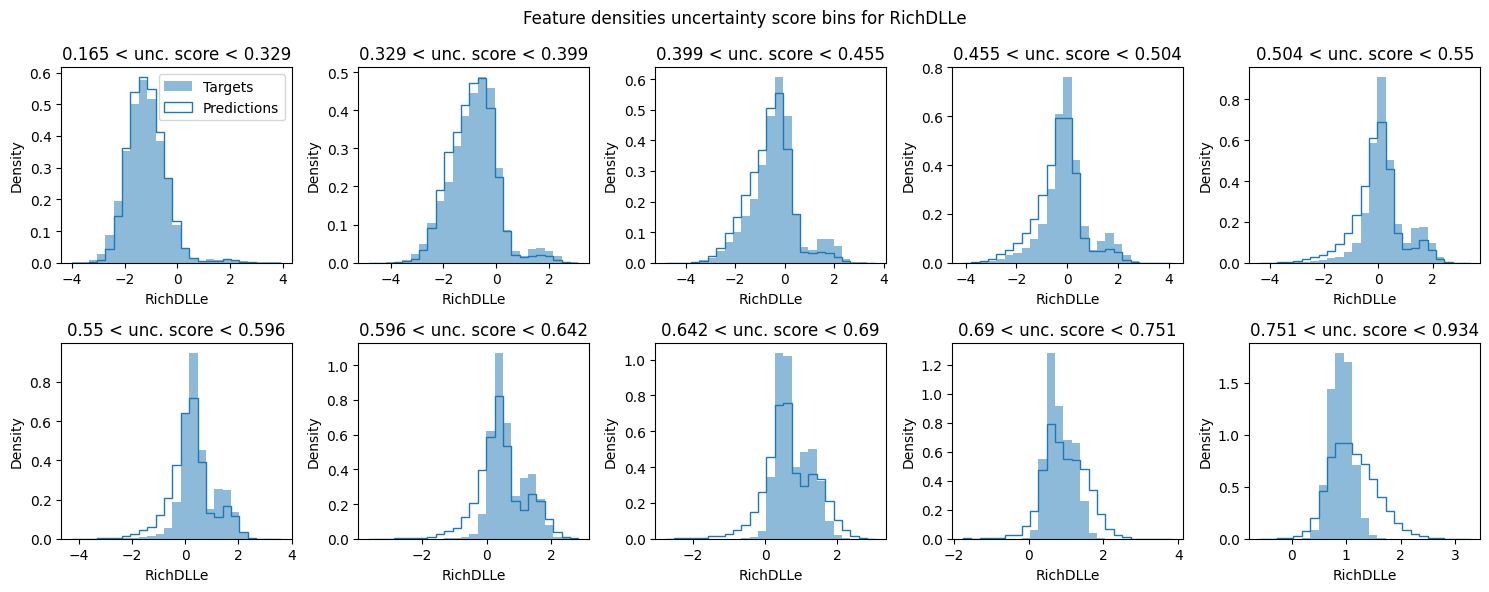

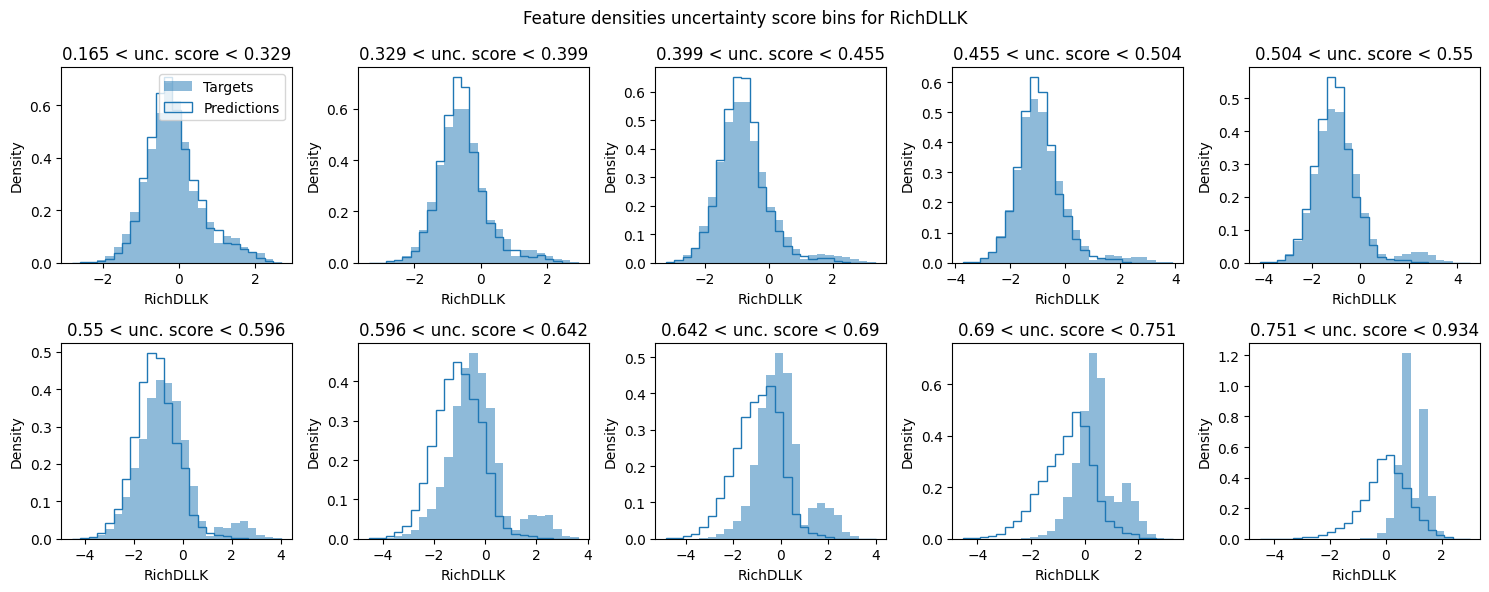

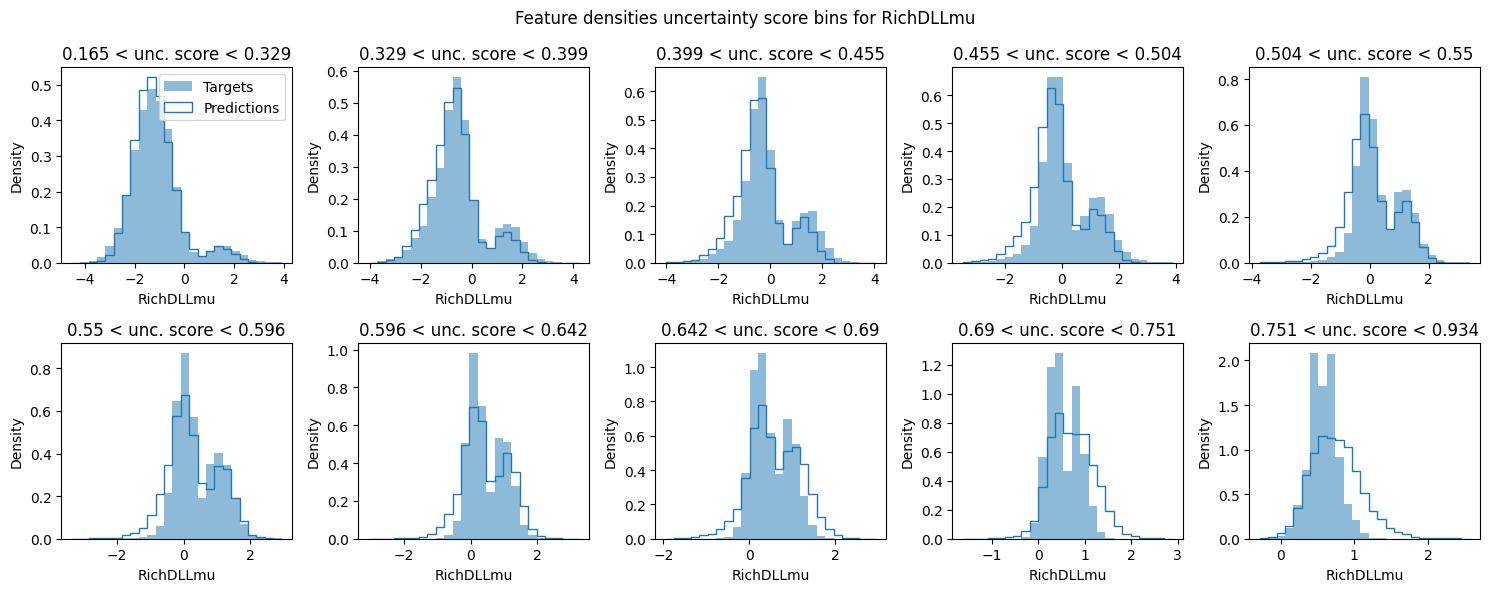

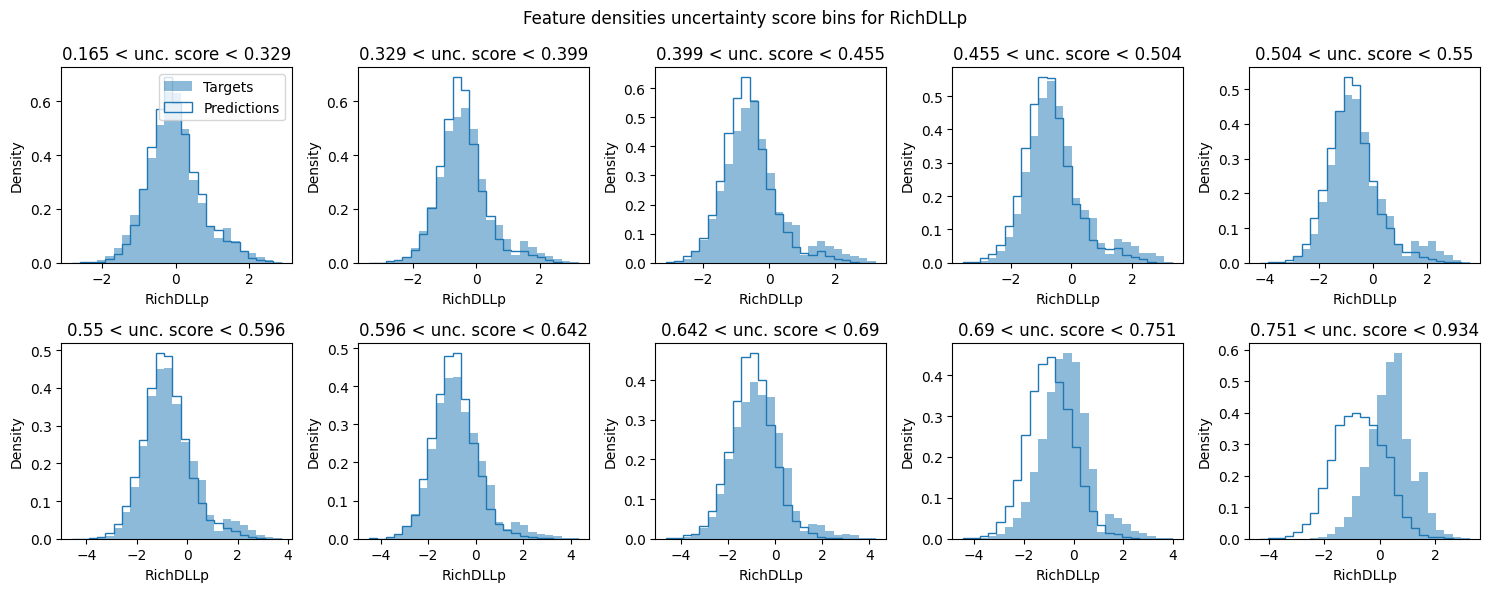

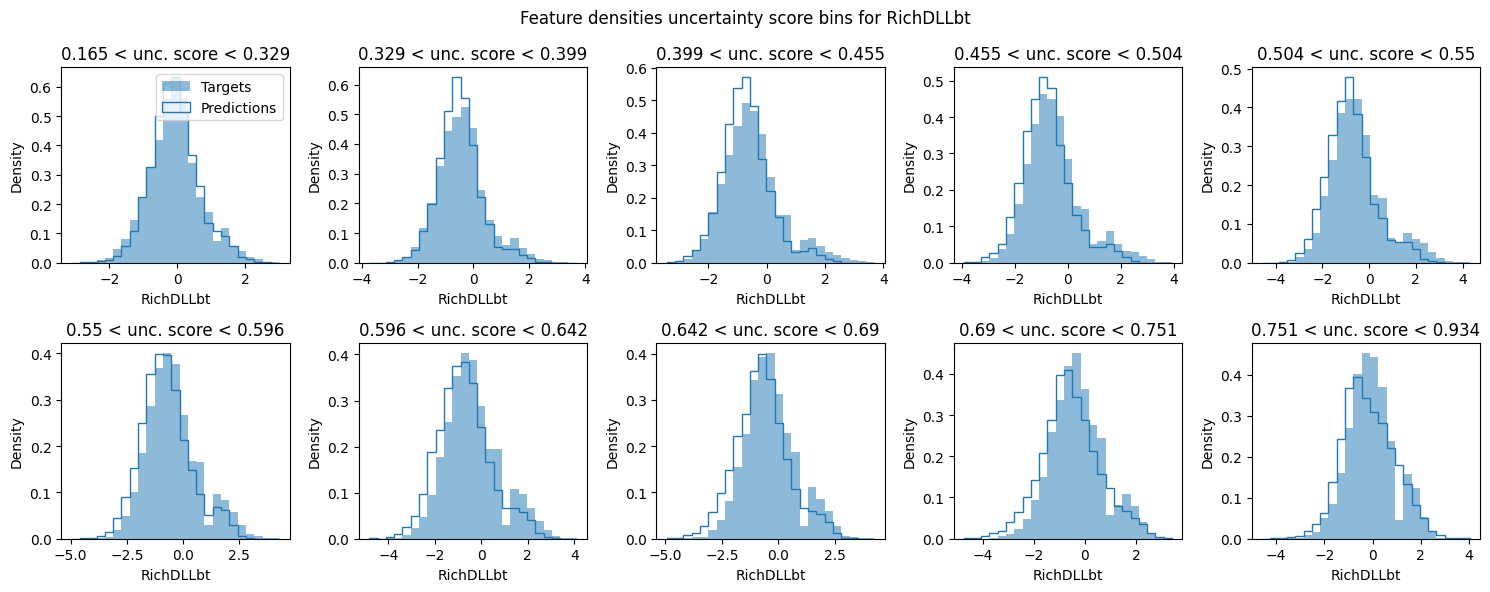

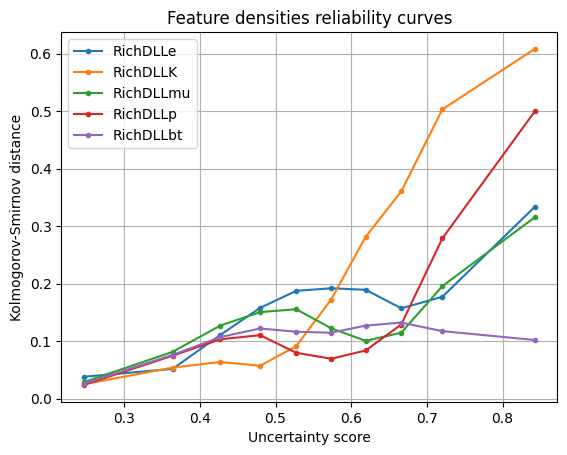

In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

#metric = 'JS'
metric = 'KS'

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i, metric=metric)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities', metric=metric)

### MCD using JS

0.01 < unc. score < 0.017: Number of observations: 10000
0.017 < unc. score < 0.019: Number of observations: 10000
0.019 < unc. score < 0.021: Number of observations: 10000
0.021 < unc. score < 0.023: Number of observations: 10000
0.023 < unc. score < 0.026: Number of observations: 10000
0.026 < unc. score < 0.029: Number of observations: 10000
0.029 < unc. score < 0.032: Number of observations: 10000
0.032 < unc. score < 0.038: Number of observations: 10000
0.038 < unc. score < 0.047: Number of observations: 10000
0.047 < unc. score < 0.157: Number of observations: 9999
JS Distances:
0.06722860177310441, 0.061212207511479946, 0.051090857322983206, 0.07063804907927528, 0.07002794955991205, 0.0915104303913713, 0.11529061704322632, 0.13942775935431254, 0.16734401163566998, 0.20368033703304358
0.001 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.024: Number of observations: 10000
0.024 < unc. score < 0.029: Number of observations: 10000
0.029 < unc. score < 0.033

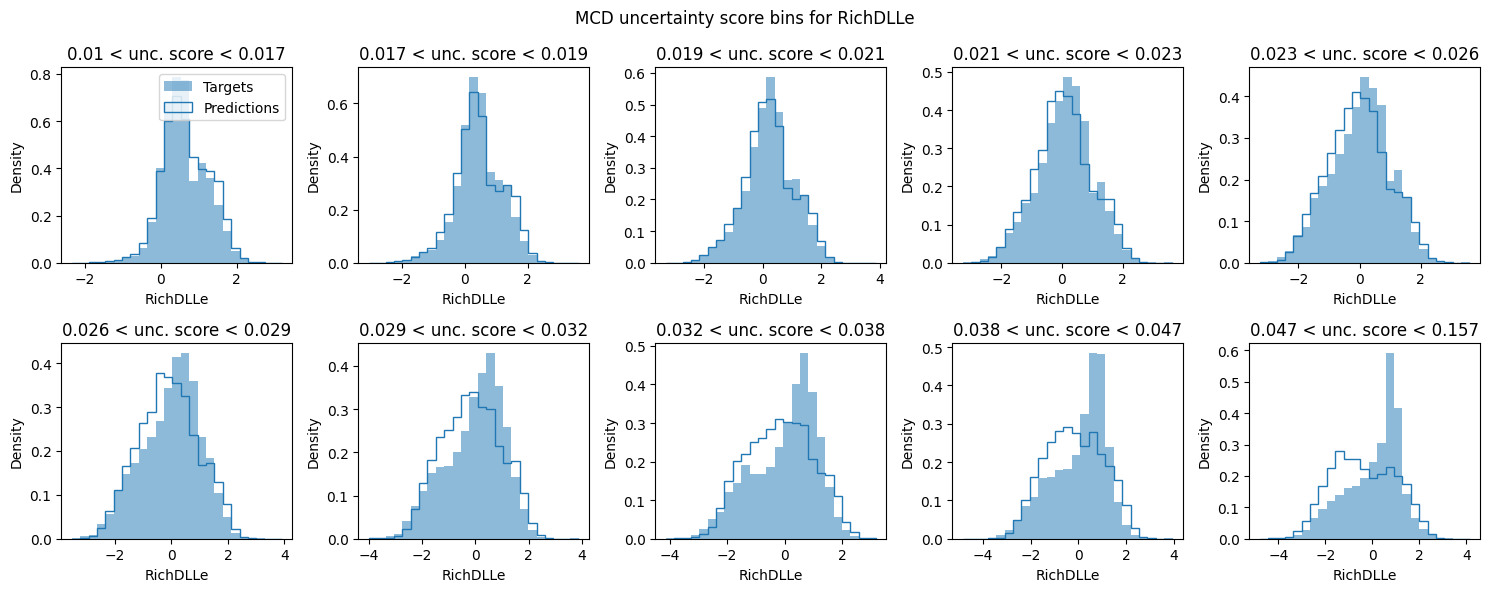

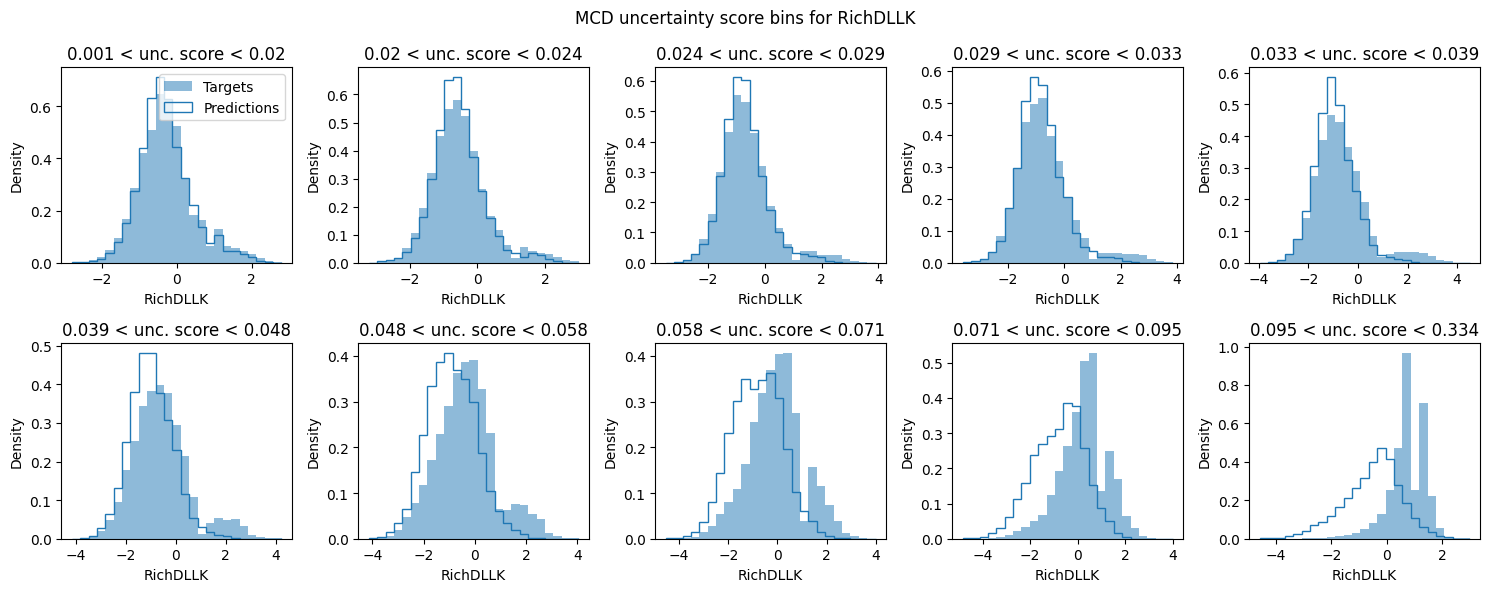

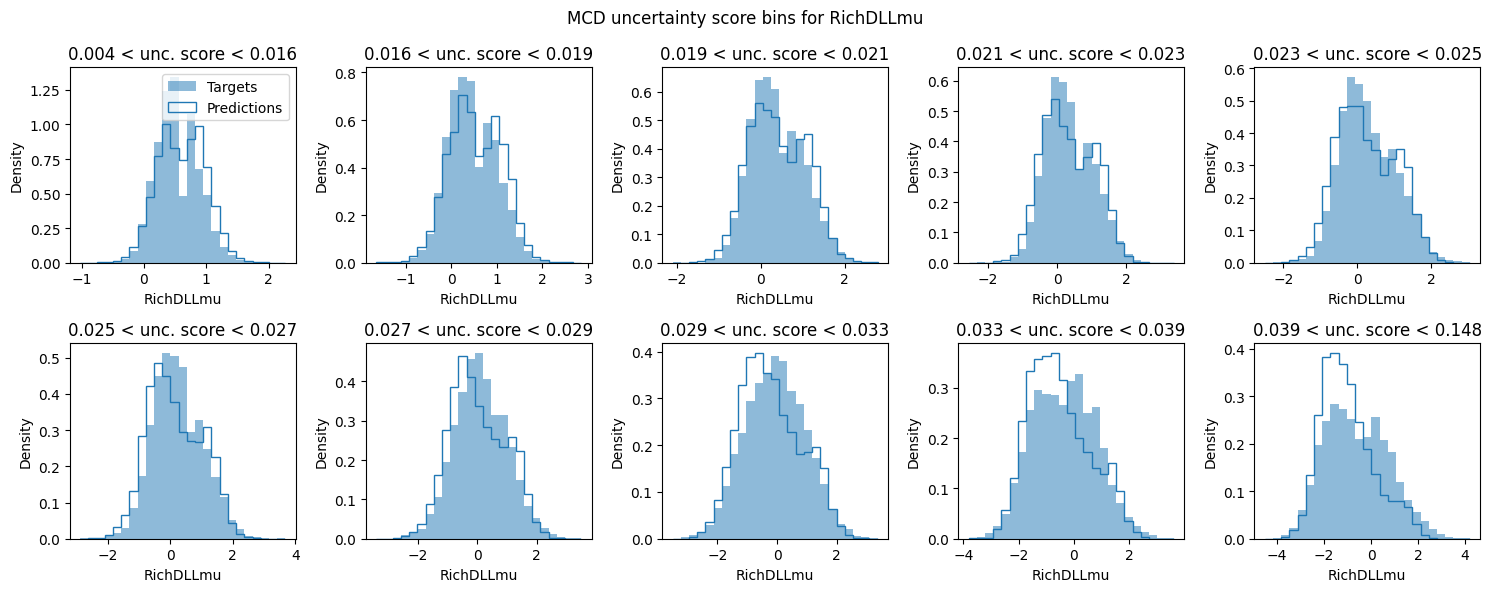

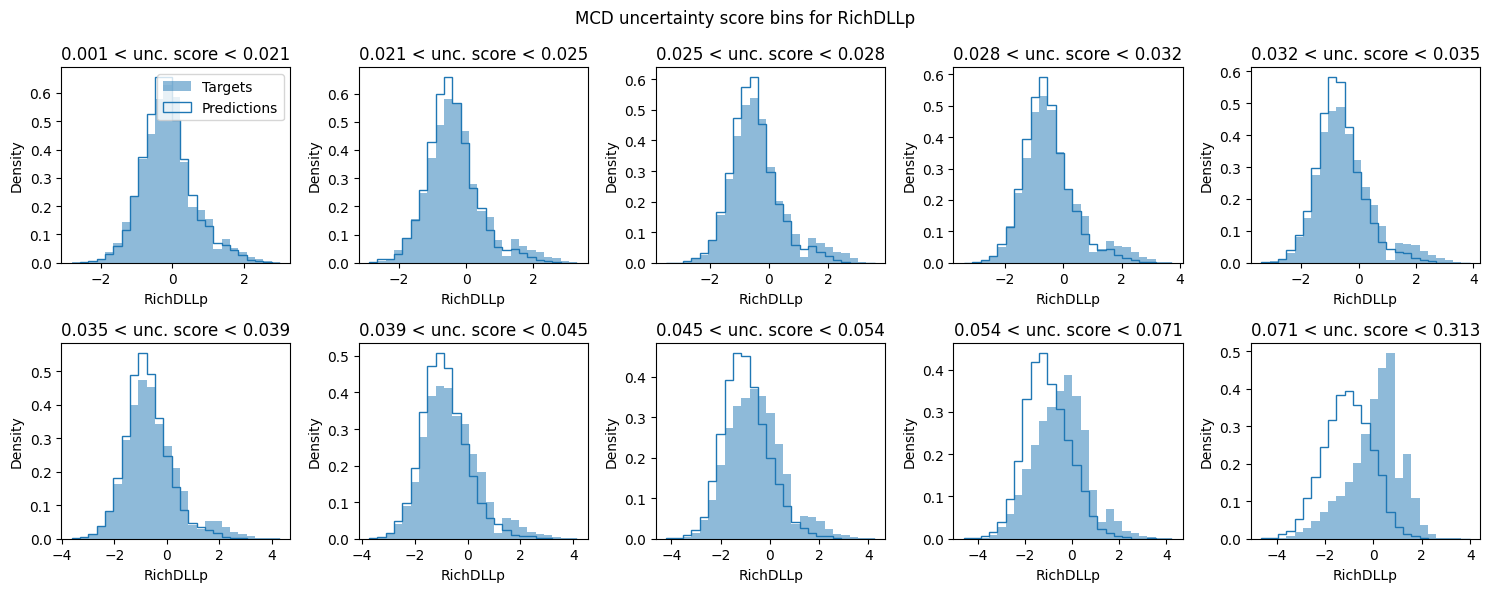

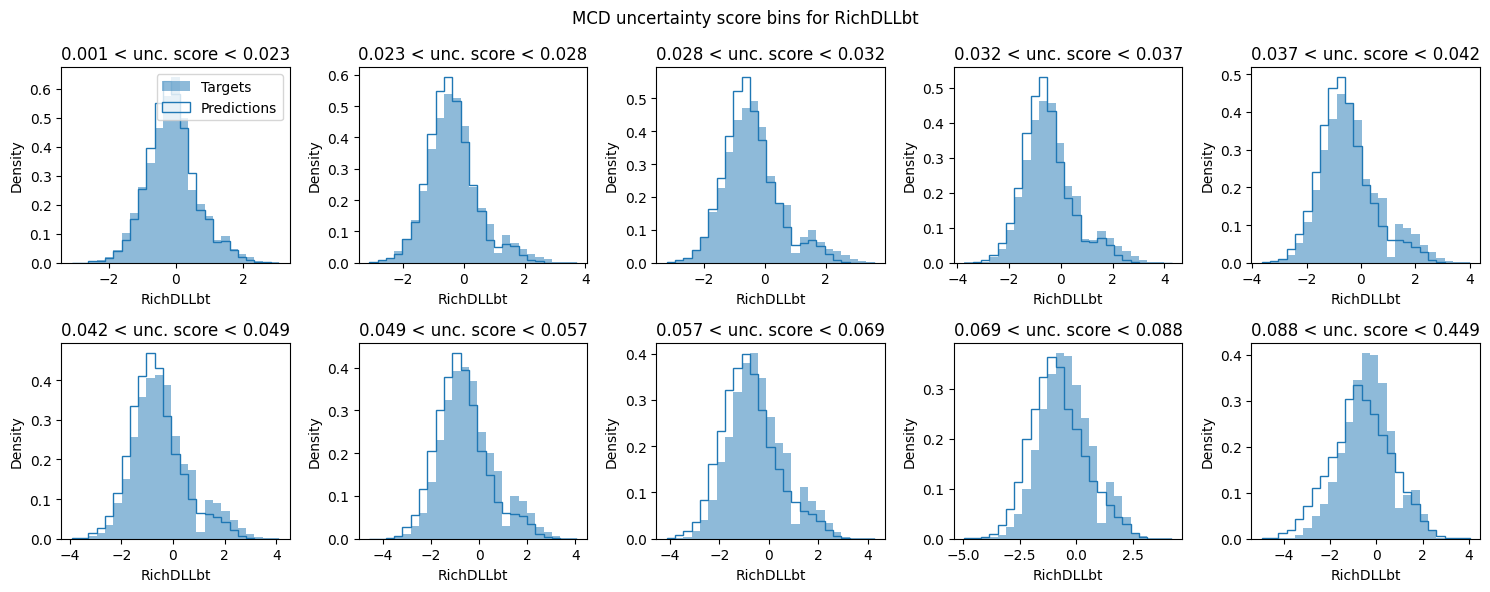

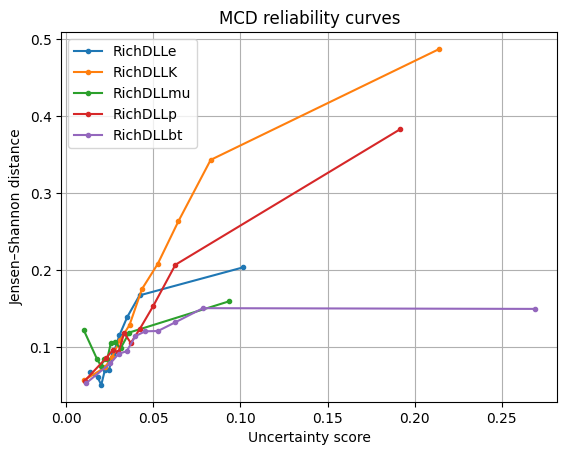

In [ ]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

metric = 'JS'
#metric = 'KS'

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i, metric=metric)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]


plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD', metric=metric)

### MCD using KS

0.01 < unc. score < 0.017: Number of observations: 10000
0.017 < unc. score < 0.019: Number of observations: 10000
0.019 < unc. score < 0.021: Number of observations: 10000
0.021 < unc. score < 0.023: Number of observations: 10000
0.023 < unc. score < 0.026: Number of observations: 10000
0.026 < unc. score < 0.029: Number of observations: 10000
0.029 < unc. score < 0.032: Number of observations: 10000
0.032 < unc. score < 0.038: Number of observations: 10000
0.038 < unc. score < 0.047: Number of observations: 10000
0.047 < unc. score < 0.157: Number of observations: 9999
KS Distances:
0.0651, 0.0419, 0.0461, 0.0617, 0.0716, 0.0906, 0.1168, 0.1348, 0.1651, 0.2224222422242224
0.001 < unc. score < 0.02: Number of observations: 10000
0.02 < unc. score < 0.024: Number of observations: 10000
0.024 < unc. score < 0.029: Number of observations: 10000
0.029 < unc. score < 0.033: Number of observations: 10000
0.033 < unc. score < 0.039: Number of observations: 10000
0.039 < unc. score < 0.048: N

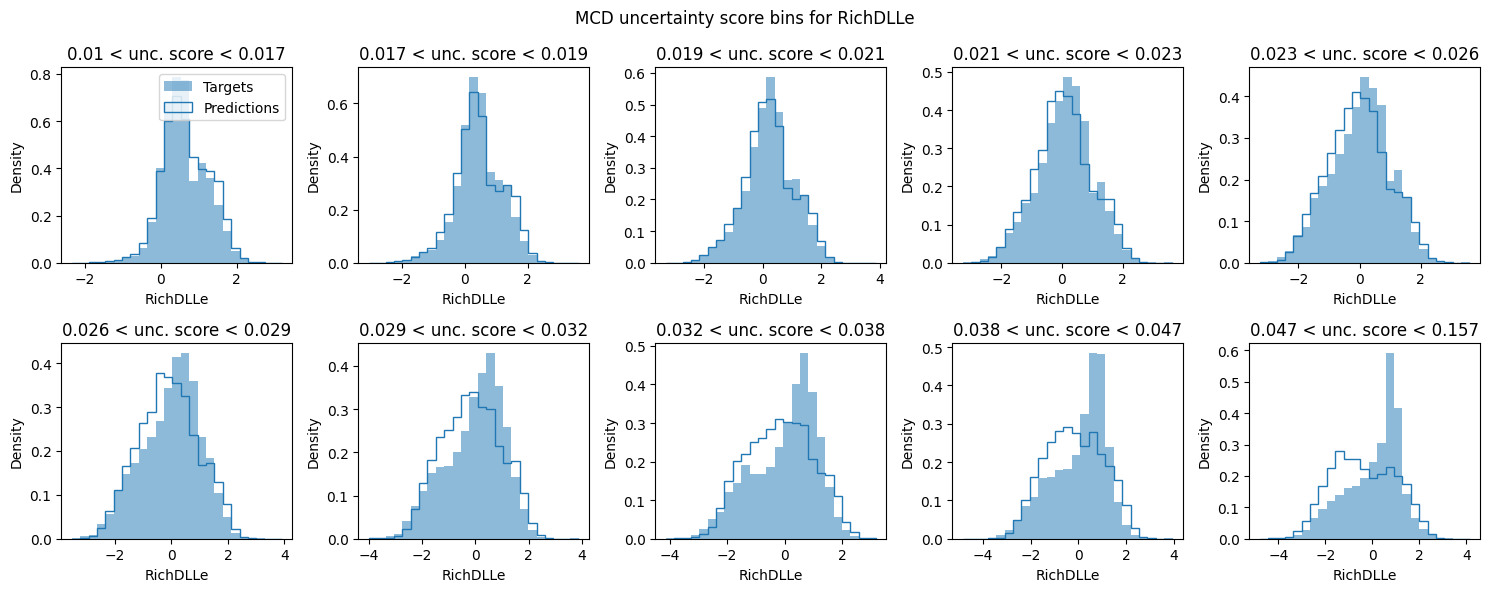

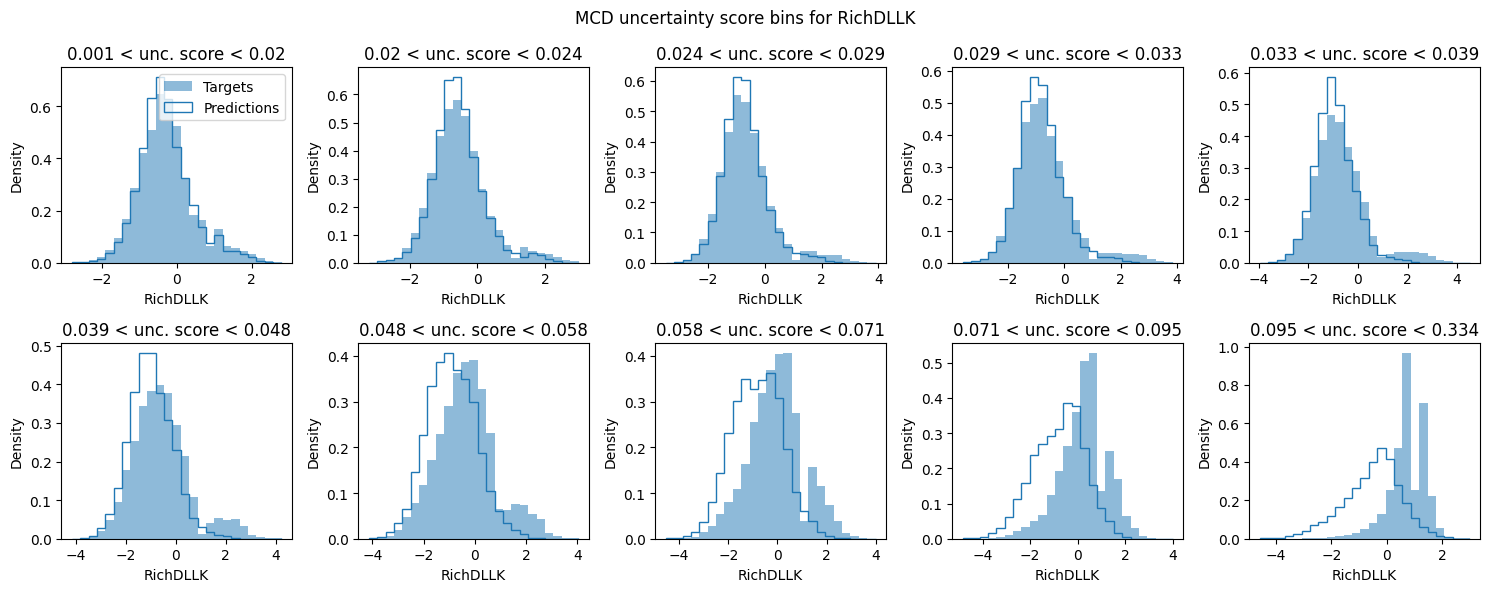

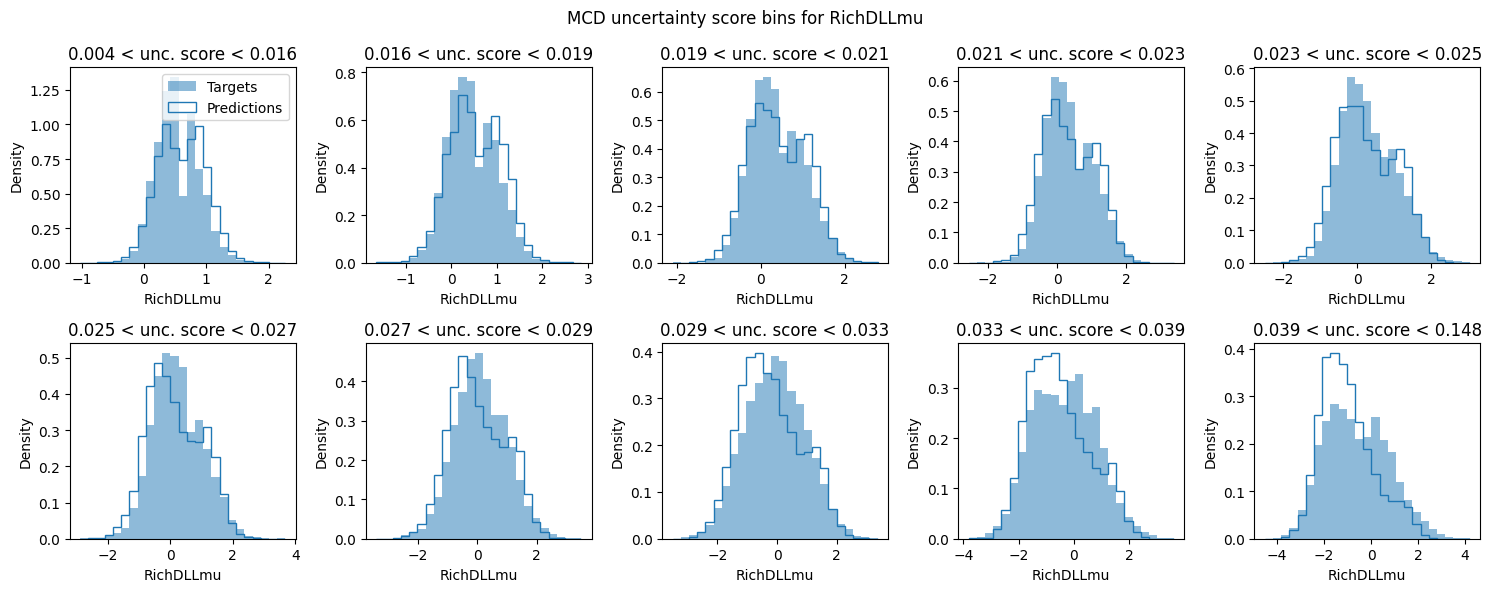

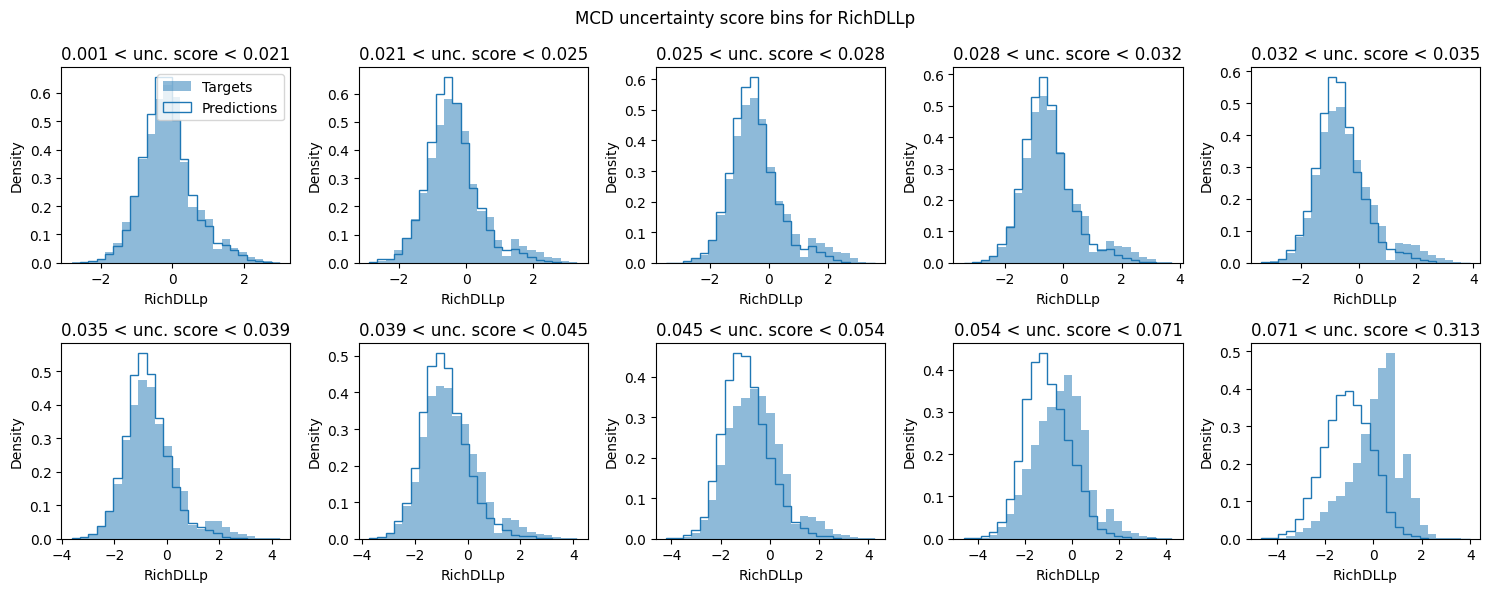

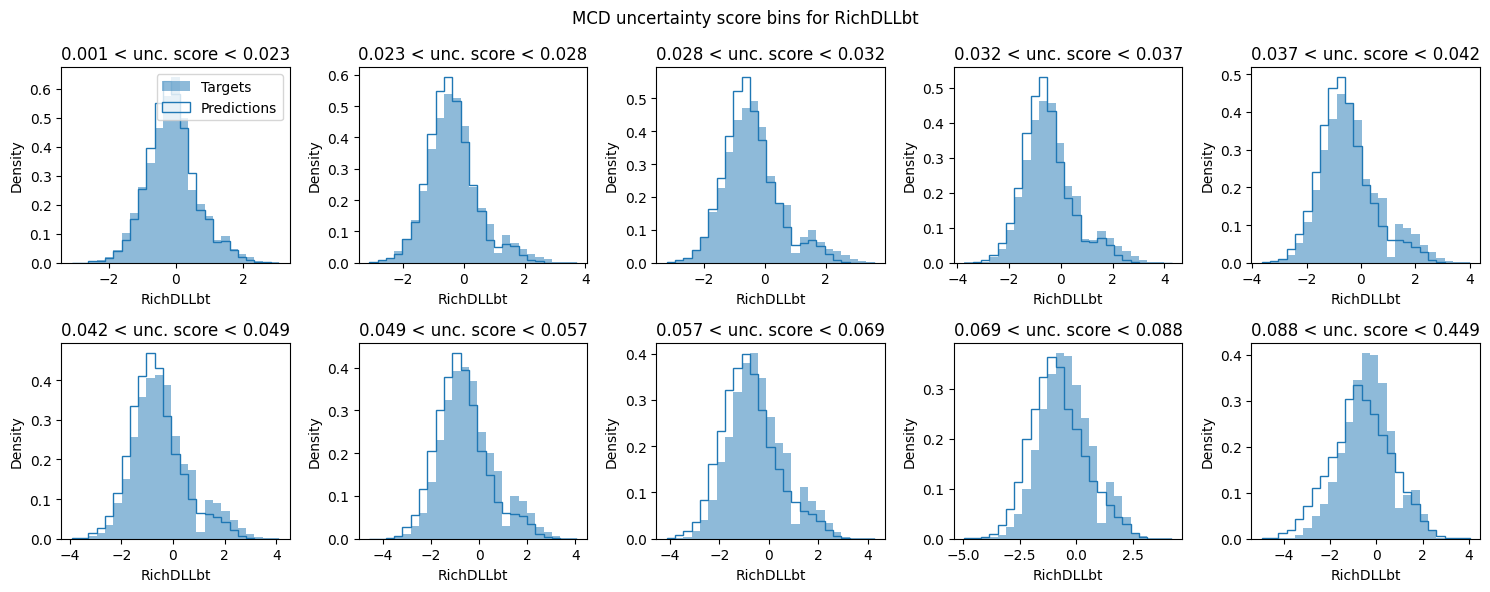

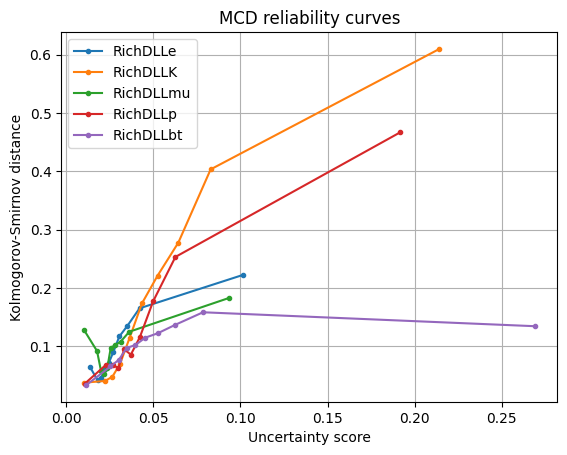

In [ ]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

#metric = 'JS'
metric = 'KS'

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i, metric=metric)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]


plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD', metric=metric)

## Uncertainty heatmaps

### FD heatmaps

In [ ]:
def uncertainty_scatter_plot_fd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  plt.title('Feature densities heatmap')
  plt.scatter(momentum, eta, .1, uncertainties, cmap='inferno')
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

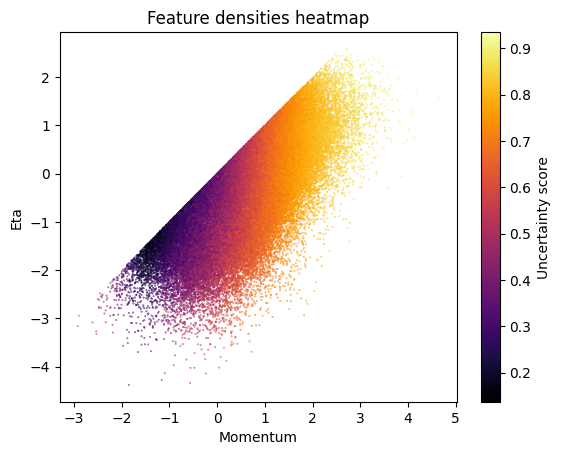

In [ ]:
uncertainty_scatter_plot_fd(x_sample, fd_uncertainty_normalized)

In [ ]:
def uncertainty_hist2d_fd(x_real, uncertainties, n_bins=100):
  uncertainties = np.array(uncertainties)

  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  momentum_edges, eta_edges = np.histogram2d(momentum, eta, n_bins)[1:]
  momentum_indices = np.digitize(momentum, momentum_edges)
  eta_indices = np.digitize(eta, eta_edges)

  heatmap = []

  for i in range(1, n_bins + 1):
    row = []
    for j in range(1, n_bins + 1):
      row += [uncertainties[(momentum_indices == j) & (eta_indices == i)].mean()]
    heatmap += [row]

  plt.title('Feature densities heatmap')
  plt.imshow(heatmap, 'inferno')
  plt.gca().invert_yaxis()
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

<ipython-input-54-97c69ed682c3>:16: RuntimeWarning: Mean of empty slice.
  row += [uncertainties[(momentum_indices == j) & (eta_indices == i)].mean()]
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


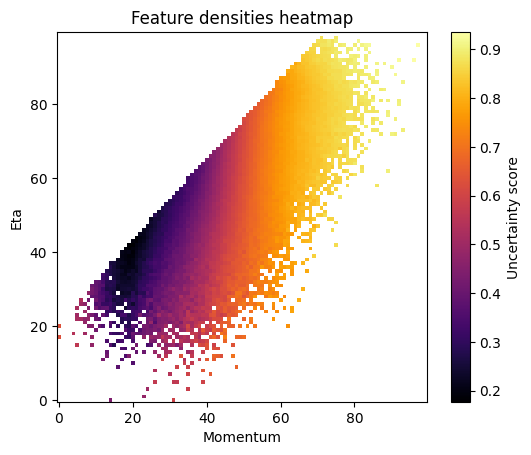

In [ ]:
uncertainty_hist2d_fd(x_sample, fd_uncertainty_normalized)

In [ ]:
from scipy.stats import binned_statistic_2d
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'

def uncertainty_binned2d_fd(x_real, uncertainties, n_bins=5, bin_size=50):

    if not isinstance(x_real, np.ndarray):
        x_real = x_real.numpy()

    if not isinstance(uncertainties, np.ndarray):
        uncertainties = uncertainties.numpy()

    momentum = x_real[:, 0]
    eta = x_real[:, 1]
    num_tracks = x_real[:, 2]

    bin_edges = np.quantile(num_tracks, np.linspace(0, 1, n_bins + 1))
    bin_indices = np.digitize(num_tracks, bin_edges, right=True)

    fig, axes = plt.subplots(1, n_bins, figsize=(16, 3))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    for i in range(n_bins):
        mask = bin_indices == (i + 1)

        x_data = momentum[mask]
        y_data = eta[mask]
        u_data = uncertainties[mask]

        x_bins = np.logspace(np.log10(x_data.min()), np.log10(x_data.max()), bin_size)
        y_bins = np.linspace(y_data.min(), y_data.max(), bin_size)

        bin_means, x_edges, y_edges, _ = binned_statistic_2d(
            x_data, y_data, u_data, statistic='mean', bins=[x_bins, y_bins]
        )

        ax = axes[i]
        ax.set_title(f'Tracks [{bin_edges[i]:.2f}, {bin_edges[i + 1]:.2f}]')
        mesh = ax.pcolormesh(x_edges, y_edges, bin_means.T, cmap='inferno', shading='auto')
        ax.set_xscale('log')
        ax.set_xlabel('Momentum')
        ax.set_ylabel('Eta')

    fig.colorbar(mesh, ax=axes, label='Uncertainty score', orientation='vertical', fraction=0.02, pad=0.01)
    plt.suptitle('Features Densities Heatmap for Different Track Ranges', y=1.05)
    plt.savefig("Features_densities_heatmap_for_different_track_ranges.svg", format="svg")
    plt.show()


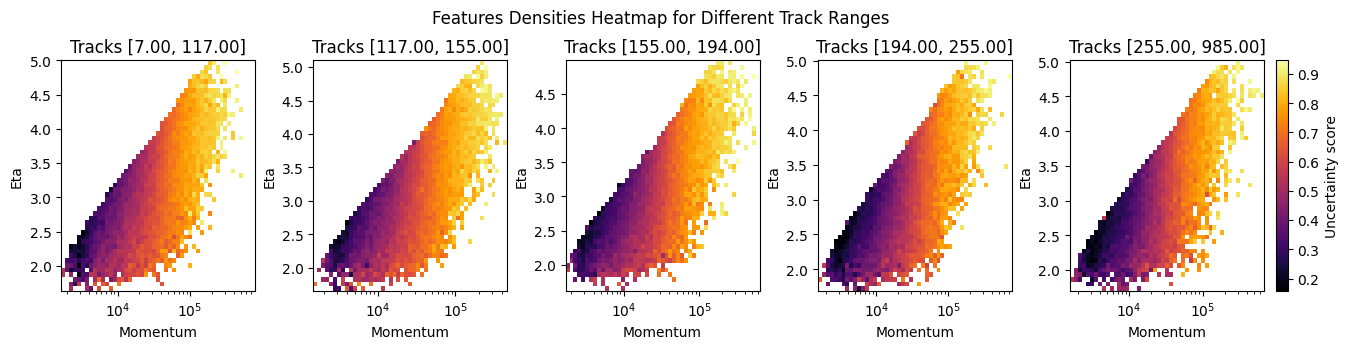

In [ ]:
uncertainty_binned2d_fd(x_sample_orig, fd_uncertainty_normalized)

### MCD heatmaps

In [ ]:
def uncertainty_scatter_plot_mcd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    ax.set_title(DLL_COLUMNS[i])
    scatter = ax.scatter(momentum, eta, .1, uncertainties[:, i], cmap='inferno')
    plt.colorbar(scatter, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

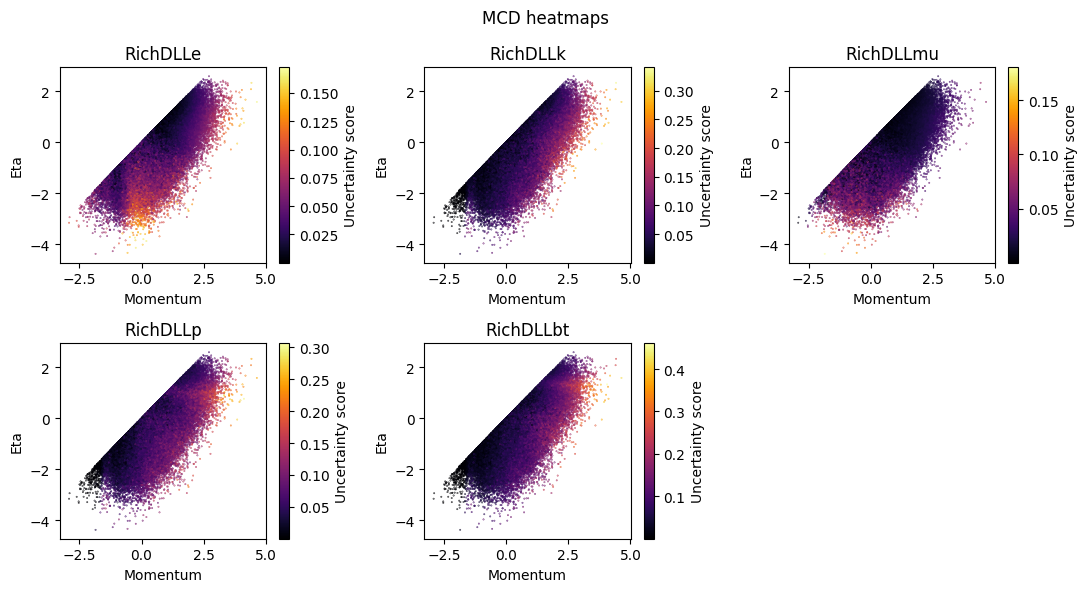

In [ ]:
uncertainty_scatter_plot_mcd(x_sample, mcd_final_uncertainty)

In [ ]:
def uncertainty_hist2d_mcd(x_real, uncertainties, n_bins=100):
  uncertainties = np.array(uncertainties)

  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for ax_index, ax in enumerate(axes.flatten()[:-1]):
    momentum_edges, eta_edges = np.histogram2d(momentum, eta, n_bins)[1:]
    momentum_indices = np.digitize(momentum, momentum_edges)
    eta_indices = np.digitize(eta, eta_edges)

    heatmap = []

    for i in range(1, n_bins + 1):
      row = []
      for j in range(1, n_bins + 1):
        row += [uncertainties[(momentum_indices == j) & (eta_indices == i), ax_index].mean()]
      heatmap += [row]

    ax.set_title(DLL_COLUMNS[ax_index])
    image = ax.imshow(heatmap, 'inferno')
    ax.invert_yaxis()
    plt.colorbar(image, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

<ipython-input-59-e99db391306d>:19: RuntimeWarning: Mean of empty slice.
  row += [uncertainties[(momentum_indices == j) & (eta_indices == i), ax_index].mean()]
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


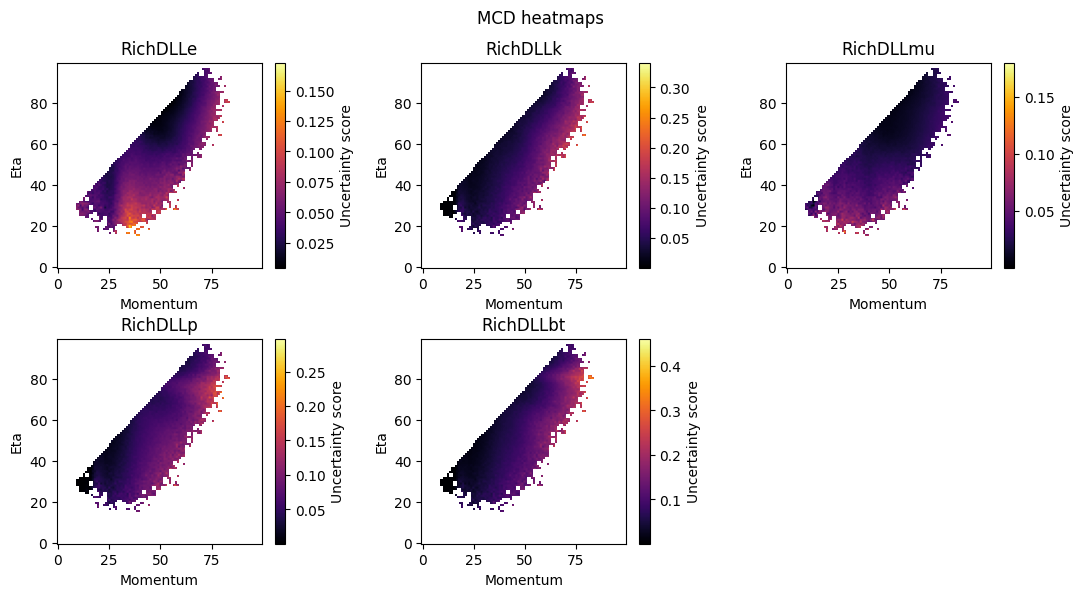

In [ ]:
uncertainty_hist2d_mcd(x_sample, mcd_final_uncertainty)

In [ ]:
from scipy.stats import binned_statistic_2d
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'

def uncertainty_binned2d_mcd(x_real, uncertainties, particle_idx, n_bins=5, dll_columns=DLL_COLUMNS, bin_size=50):

    if not isinstance(x_real, np.ndarray):
      x_real = x_real.numpy()

    if not isinstance(uncertainties, np.ndarray):
      uncertainties = uncertainties.numpy()

    momentum = x_real[:, 0]
    eta = x_real[:, 1]
    num_tracks = x_real[:, 2]

    bin_edges = np.quantile(num_tracks, np.linspace(0, 1, n_bins + 1))
    bin_indices = np.digitize(num_tracks, bin_edges, right=True)

    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    for i in range(n_bins):
        ax = axes[i]

        bin_mask = bin_indices == (i + 1)
        x_data = momentum[bin_mask]
        y_data = eta[bin_mask]
        u_data = uncertainties[bin_mask, particle_idx]

        x_bins = np.logspace(np.log10(x_data.min()), np.log10(x_data.max()), bin_size)
        y_bins = np.linspace(y_data.min(), y_data.max(), bin_size)

        bin_means, x_edges, y_edges, _ = binned_statistic_2d(
            x_data, y_data, u_data, statistic='mean', bins=[x_bins, y_bins]
        )

        ax = axes[i]
        ax.set_title(f'Tracks [{bin_edges[i]:.2f}, {bin_edges[i + 1]:.2f}]')
        mesh = ax.pcolormesh(x_edges, y_edges, bin_means.T, cmap='inferno', shading='auto')
        ax.set_xscale('log')
        ax.set_xlabel('Momentum(MeV/c)')
        ax.set_ylabel('Eta')

        plt.suptitle(f'MCD Heatmap for Different Track Ranges for particle {DLL_COLUMNS[particle_idx]}', y=1.05)

    fig.colorbar(mesh, ax=axes, label='Uncertainty score', orientation='vertical', fraction=0.02, pad=0.01)
    plt.savefig(f'MCD_Heatmap_for_Different_Track_Ranges_for_particle_{DLL_COLUMNS[particle_idx]}.svg', format="svg")
    plt.show()

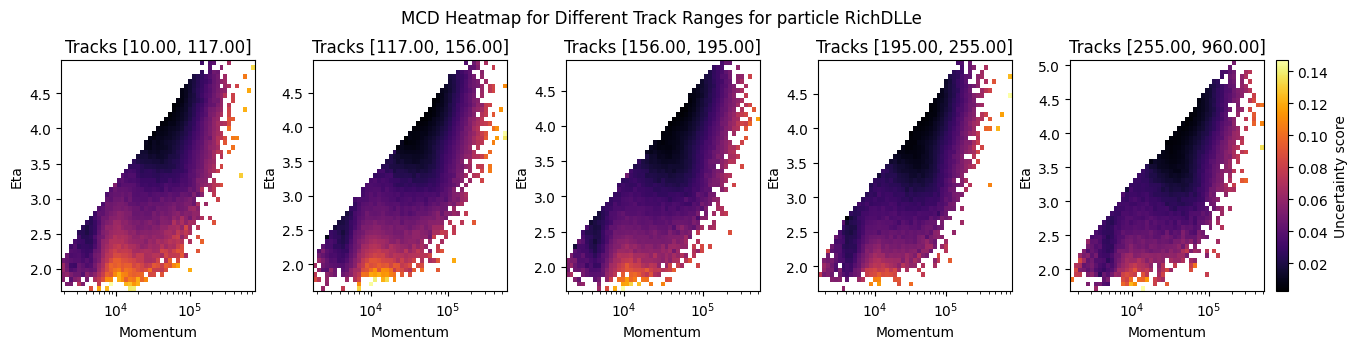

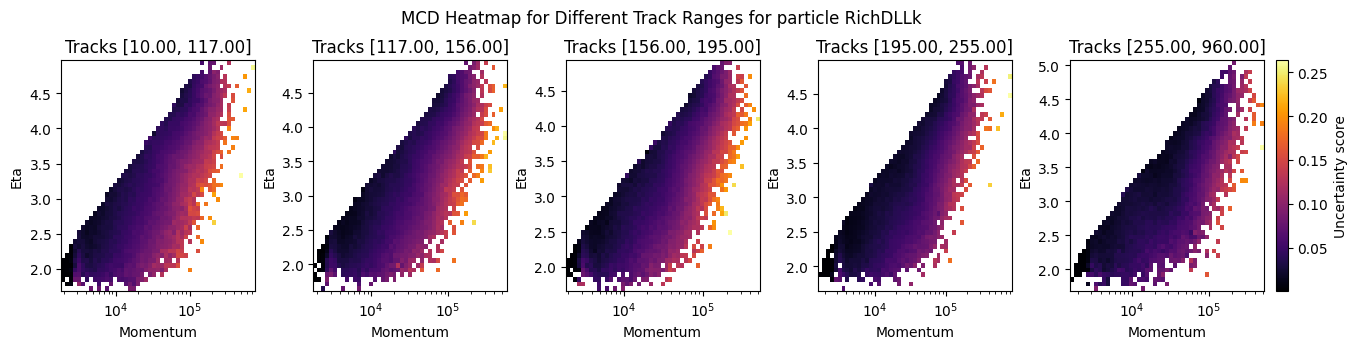

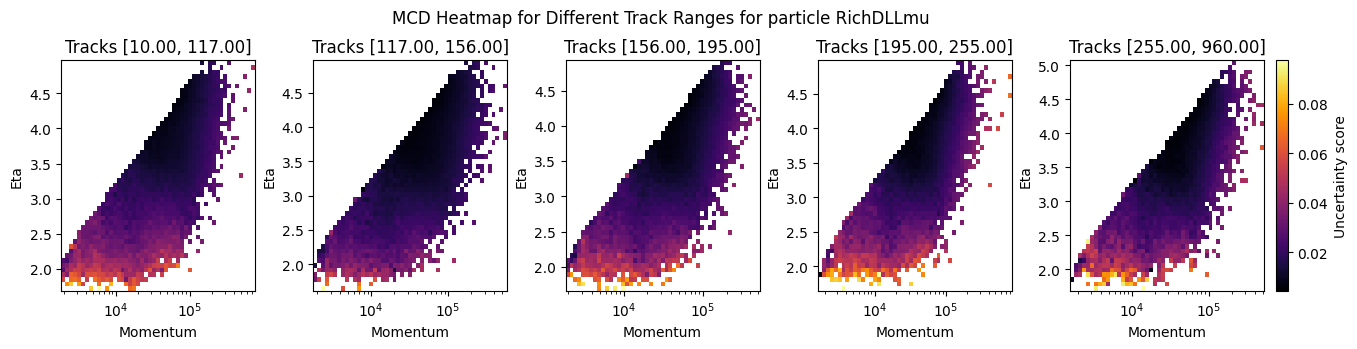

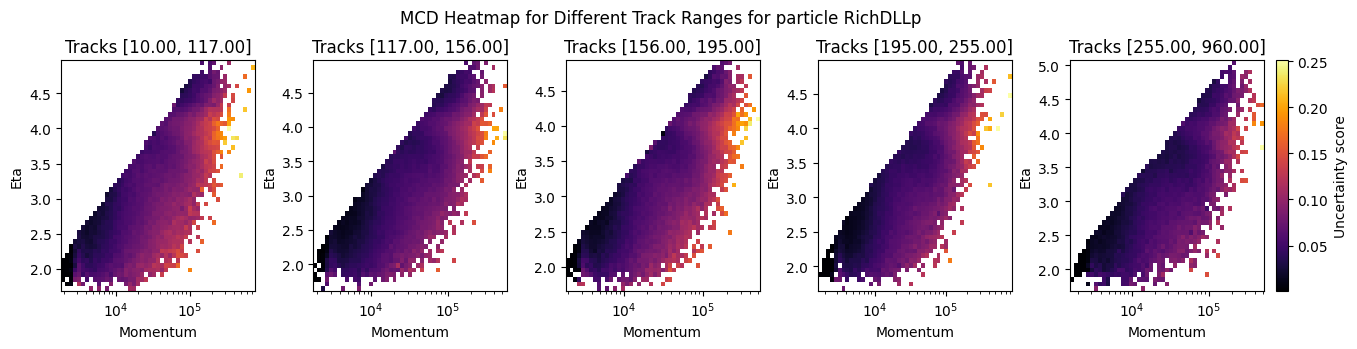

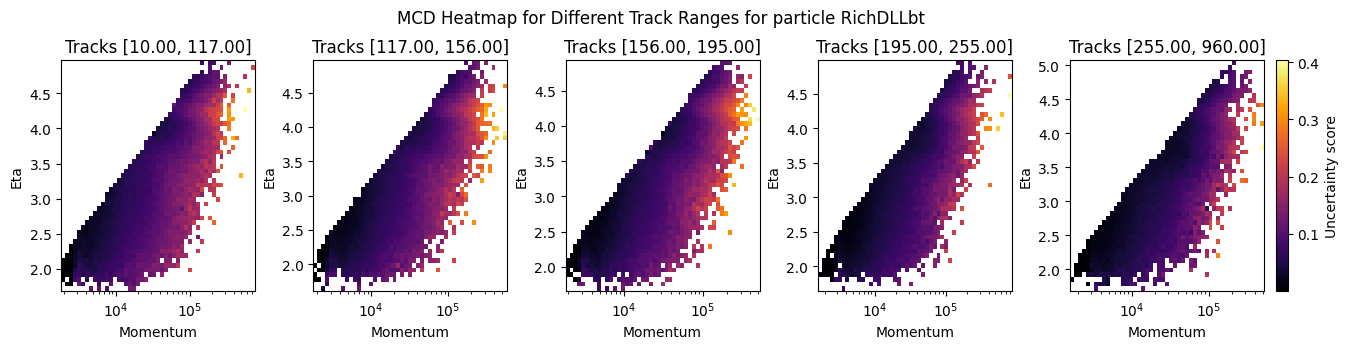

In [ ]:
for i in range(5):
  uncertainty_scores = mcd_uncertainty[:, i]
  bin_edges = np.quantile(uncertainty_scores, np.linspace(0, 1, 11))
  limit = bin_edges[9]

  reduced_x_sample = x_sample_orig[uncertainty_scores < limit]
  reduced_uncertainty = mcd_uncertainty[uncertainty_scores < limit]
  #print(reduced_x_sample.shape)
  #print(reduced_uncertainty.shape)
  uncertainty_binned2d_mcd(reduced_x_sample, reduced_uncertainty, i)

# Efficiency plots

In [ ]:
def select_threshold(feature, quantile=0.1):
    return np.quantile(feature, quantile)

def efficiency_bins(targets, threshold, particle_index):
    def compute_efficiency(y):
        return (y > threshold).mean()

    def compute_error(y):
        err = (y < threshold).sum() * (y > threshold).sum() / y.size**3
        return np.sqrt(err)

    efficiencies = []
    errors = []

    for target in targets:
        eff = compute_efficiency(target[:, particle_index])
        err = compute_error(target[:, particle_index])

        efficiencies.append(eff)
        errors.append(err)

    return efficiencies, errors

def compute_bin_indices(data, n_bins):
  bin_edges = np.linspace(data.min(), data.max(), n_bins + 1)
  indices = np.digitize(data, bin_edges)
  return indices

def plot_efficiencies(y_sample, t_generated, uncertainties, quantiles, n_bins=10, dll_columns=DLL_COLUMNS):
  y_sample = np.array(y_sample)
  t_generated = np.array(t_generated)
  uncertainties = np.array(uncertainties)

  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  indices = compute_bin_indices(uncertainties, n_bins)

  bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
  bins_likelihoods = [uncertainties[indices == i].mean() for i in range(1, n_bins + 1)]

  for idx, ax in zip(range(5), axes.flatten()):
      for quantile in quantiles:
          threshold = select_threshold(y_sample[:, idx], quantile)
          eff, err = efficiency_bins(bins_targets, threshold, idx)

          plot = ax.plot(bins_likelihoods, eff, '.-', label=f'Quantile = {int(quantile * 100)}%')
          ax.errorbar(bins_likelihoods, eff, err, color=plot[0].get_color())

      ax.set_title(dll_columns[idx])
      ax.set_axisbelow(True)
      ax.grid()
      ax.set_xlabel("Bin likelihood")
      ax.set_ylabel("Efficiency")

  axes[-1, -1].axis(False)
  handles, labels = ax.get_legend_handles_labels()
  plt.legend(handles, labels, loc='upper left')

  plt.tight_layout()
  plt.show()

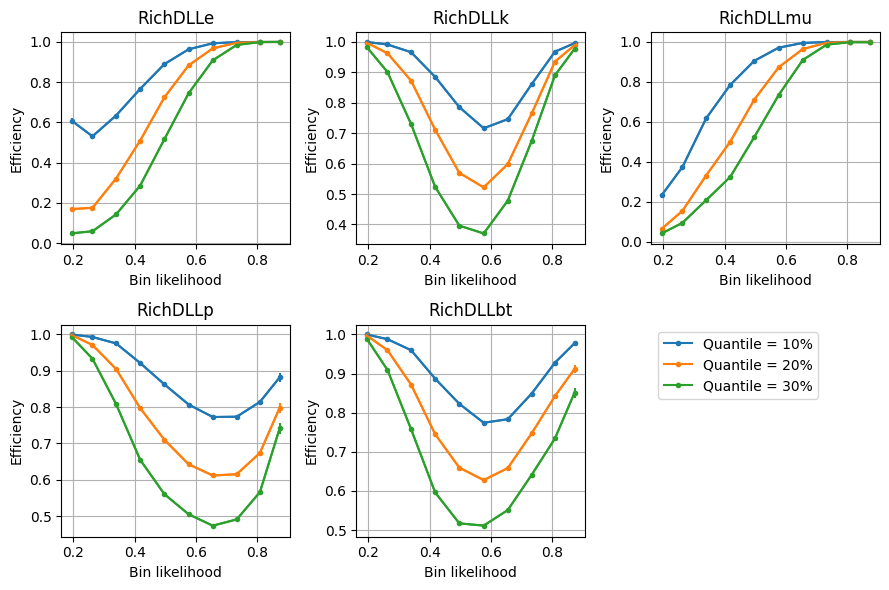

In [ ]:
plot_efficiencies(y_sample, t_generated, fd_uncertainty_normalized, [.1, .2, .3])

##Plot Efficiencies by particle

In [ ]:
def plot_efficiencies_by_particle(y_sample, t_generated, uncertainties, quantiles, uncertainty_type="MCD", particle_idx=0, n_bins=10, dll_columns=DLL_COLUMNS):
    y_sample = np.array(y_sample)
    t_generated = np.array(t_generated)
    uncertainties = np.array(uncertainties)

    fig, axes = plt.subplots(2, 3, figsize=(9, 6))

    colors = plt.colormaps['tab10']

    if uncertainty_type == "MCD":
        uncertainties_column = uncertainties[:, particle_idx]
    else:
        uncertainties_column = uncertainties


    bin_edges = np.quantile(uncertainties_column, np.linspace(0, 1, n_bins + 1))
    indices = np.digitize(uncertainties_column, bin_edges, right=True)

    bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
    bins_real = [y_sample[indices == i] for i in range(1, n_bins + 1)]
    bins_likelihoods = [uncertainties_column[indices == i].mean() for i in range(1, n_bins + 1)]

    for idx, ax in zip(range(len(quantiles)), axes.flatten()):
        quantile = quantiles[idx]
        threshold = select_threshold(y_sample[:, particle_idx], quantile)

        eff_gen, err_gen = efficiency_bins(bins_targets, threshold, particle_idx)
        eff_real, err_real = efficiency_bins(bins_real, threshold, particle_idx)



        ax.plot(bins_likelihoods, eff_gen, '.-', color=colors(0), label='Generated')

        ax.fill_between(bins_likelihoods, np.array(eff_gen) - np.array(err_gen),
                        np.array(eff_gen) + np.array(err_gen), color=colors(0), alpha=0.3)

        ax.plot(bins_likelihoods, eff_real, '.-', color=colors(20), label='Real')

        ax.fill_between(bins_likelihoods, np.array(eff_real) - np.array(err_real),
                        np.array(eff_real) + np.array(err_real), color=colors(20), alpha=0.3)

        ax.set_title(f'Threshold {int(quantile * 100)}%')
        ax.set_axisbelow(True)
        ax.grid()
        ax.set_xlabel("Uncertainty Score")
        ax.set_ylabel("Efficiency")
        ax.set_ylim(0, 1.10)

    axes[-1, -1].axis(False)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.73, 0.45), fontsize='small')

    plt.suptitle(f'{uncertainty_type} efficiencies plot for {dll_columns[particle_idx]}')

    plt.tight_layout()
    plt.show()

### Plot FD efficiencies

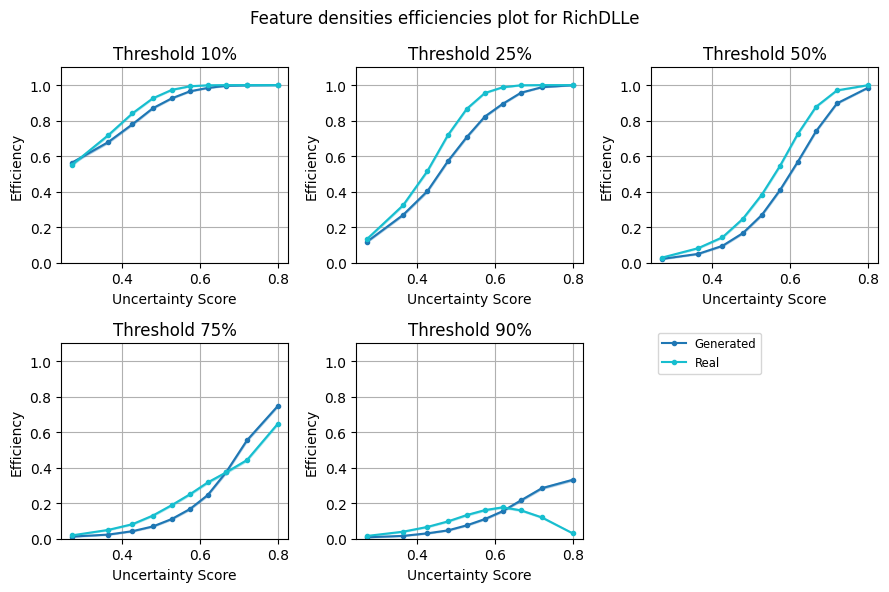

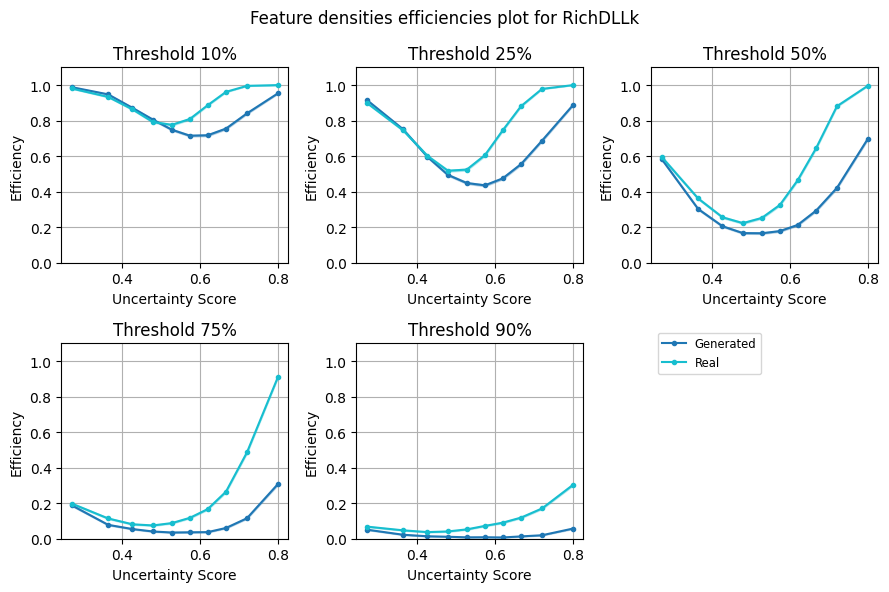

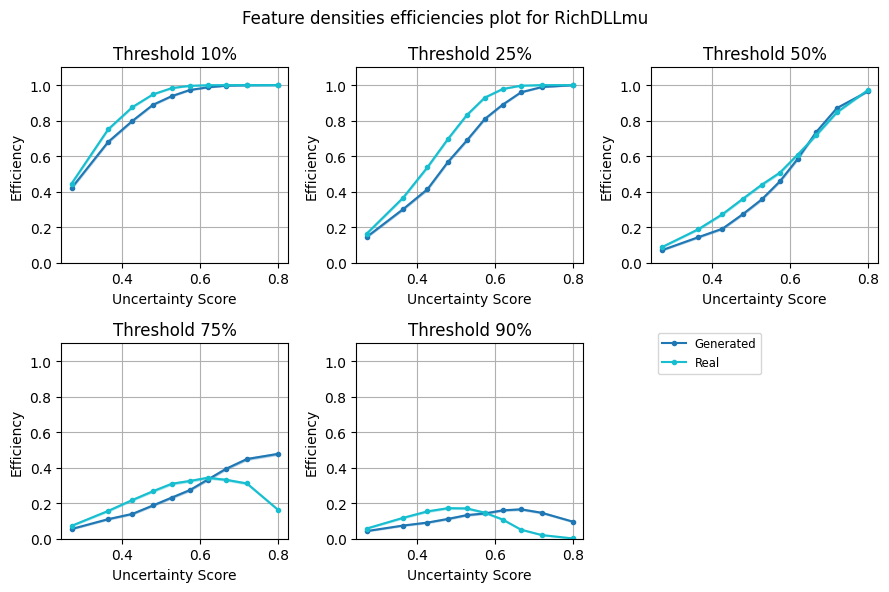

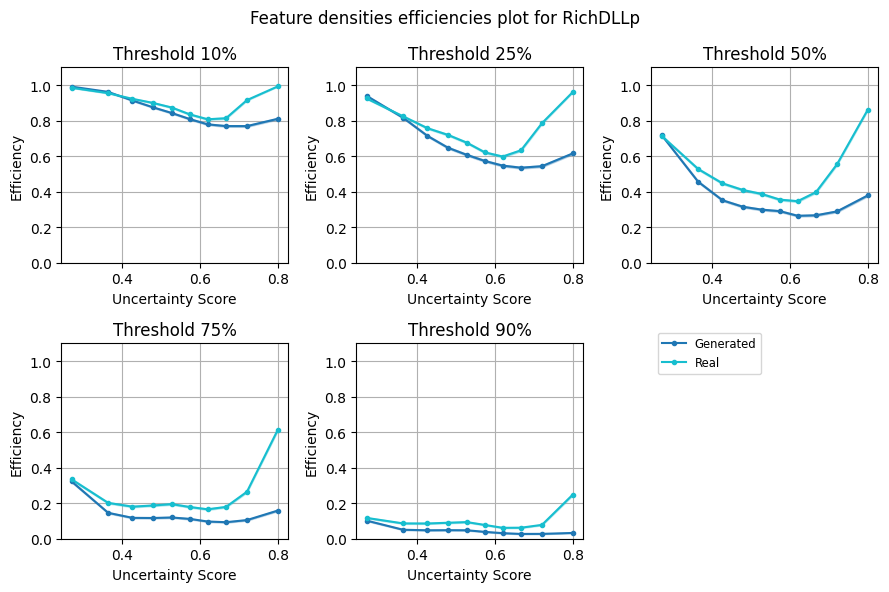

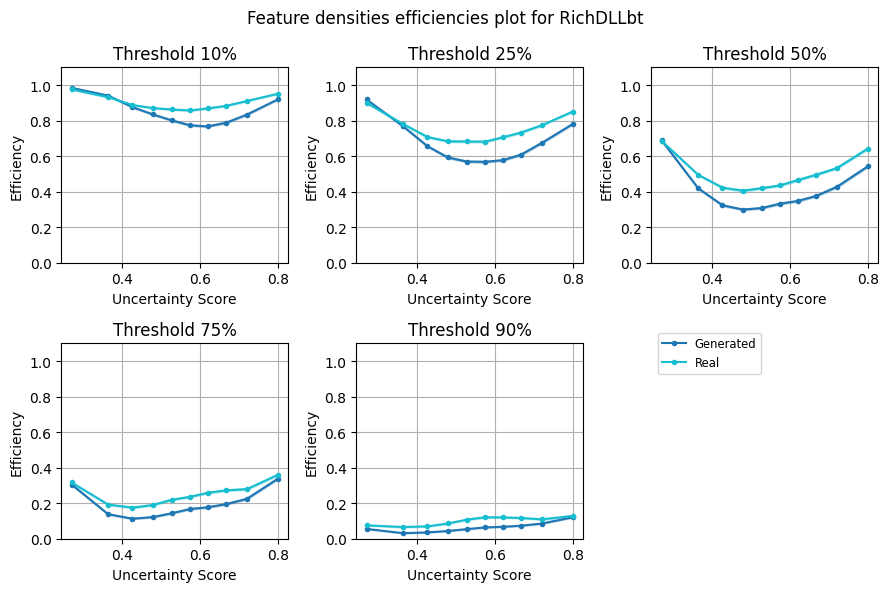

In [ ]:
for i in range(5):
  plot_efficiencies_by_particle(y_sample, t_generated, fd_uncertainty_normalized, [.1, .25, .5, .75, .9], "Feature densities", i)

### Plot MCD efficiencies

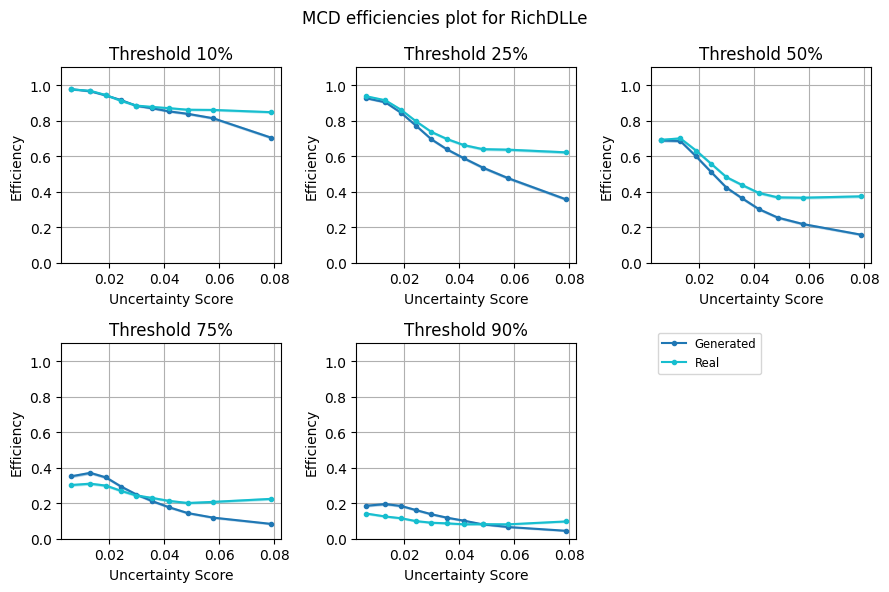

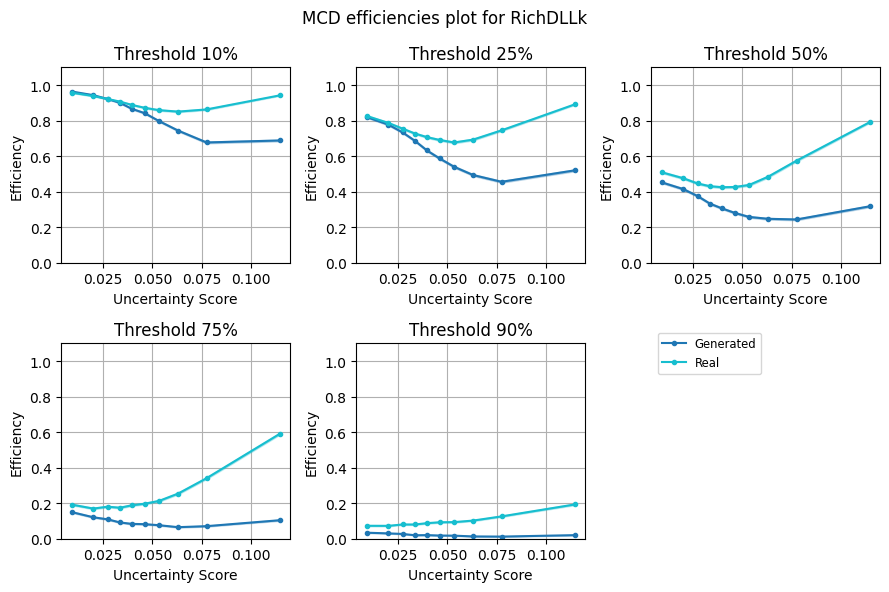

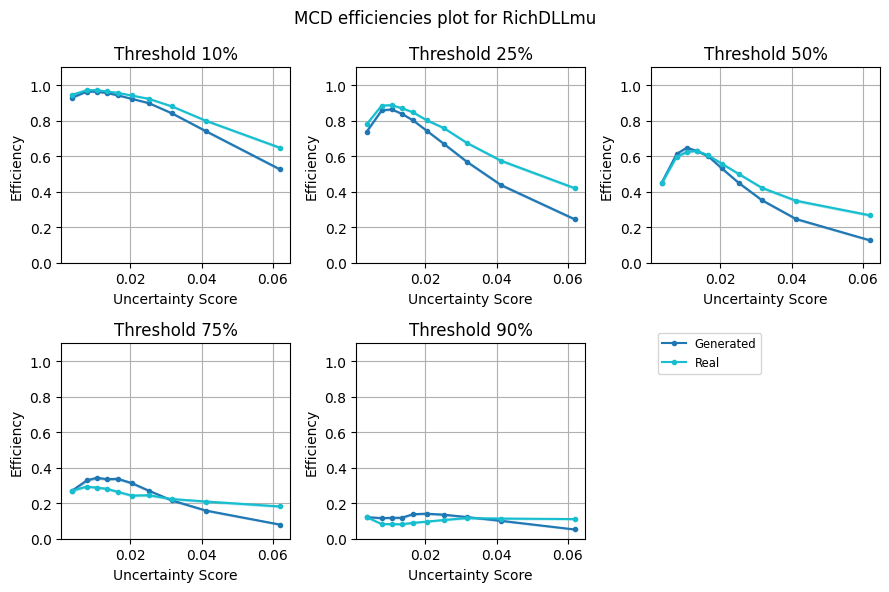

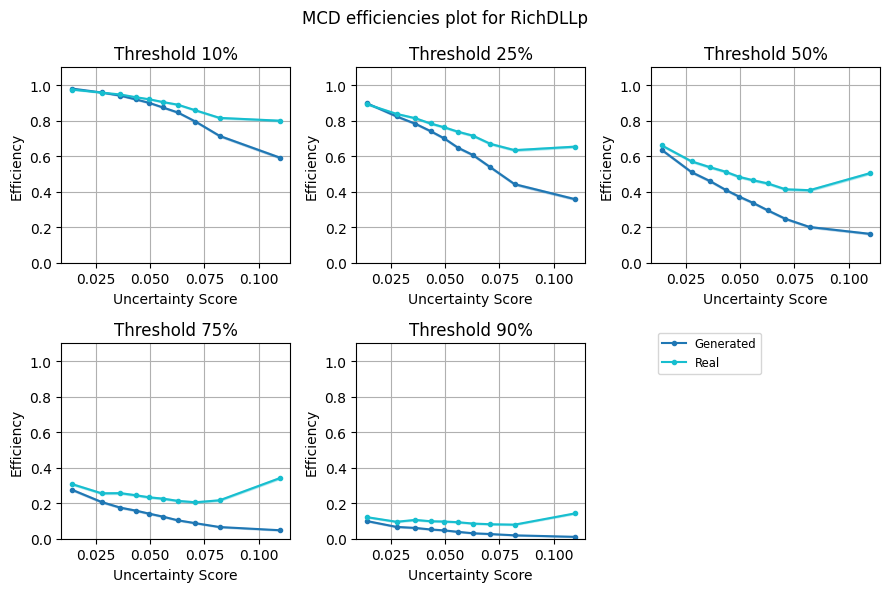

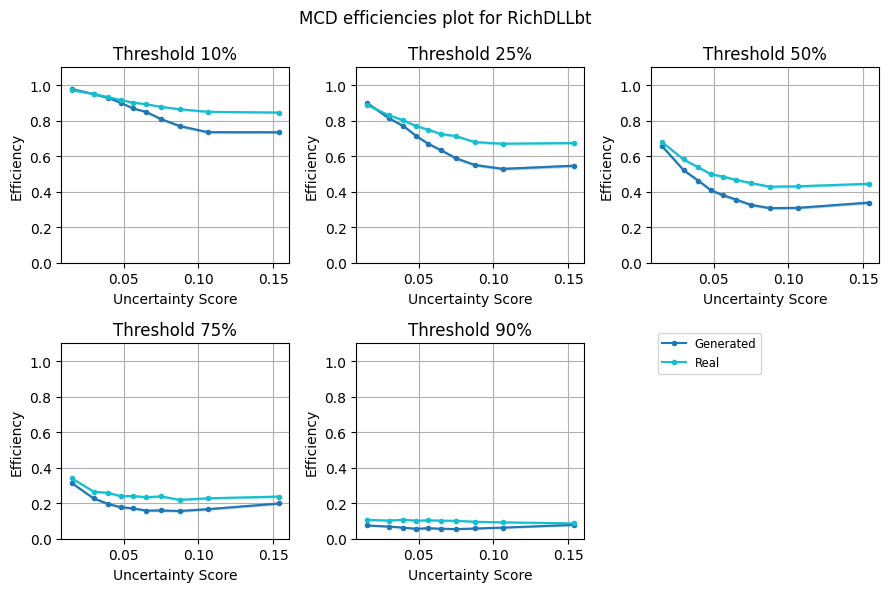

In [ ]:
for i in range(5):
  plot_efficiencies_by_particle(y_sample, t_generated, mcd_final_uncertainty, [.1, .25, .5, .75, .9], "MCD", i)

# Archived

#### FD with integration method


In [ ]:
fd_uncertainty_integration, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, n_fit_samples=100,
                                                  likelihood_method='integration')

print('Feature Densities using INTEGRATION uncertainty score for x_sample:')
fd_uncertainty_integration

In [ ]:
# Save FD uncertainties with integration
np.save(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy', fd_uncertainty_integration)

In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_integration, 'Feature densities', particle_index = i, n_rows = 3, n_cols = 3)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

#### MCD / Linear bins

In [ ]:
all_mcd_bin_edges, all_mcd_js_distances = [], []


for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', particle_index = i)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

In [ ]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD')

#### FD / Linear bins

In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', particle_index = i)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')